- fhs_flashsale_product: (Thông tin flashsale của product)
    * period_id : id của flashsale
    * product_id : id của product 
    * original_price : giá gốc
    * flashsale_price : giá sale
    * total_items : số lượng sale
    
- fhs_flashsale_period: (Chứa thông tin flashsale về thời gian)
    * id: id của flashsale (== period_id của fhs_flashsale_product)
    * start_date, end_date: time bắt đầu kết thúc sale 
    * các cột khác không quan tâm
    
- fhs_catalog_product_entity: (Thông tin discount và ngày bắt đầu bán)
    * entity_id: id của product (==product_id trong fhs_flashsale_product)
    * sku : là mã sản phẩm (duy nhất và là khóa của sản phẩm dùng để truy các thông tin khác về sản phẩm)
    * created_at : ngày bắt đầu bán
    * discount_percent : phần trăm giảm giá so với giá bìa (trừ flashsale còn giá sản phẩm mọi lúc sẽ là giá gốc trừ đi disount này)

- fhs_cataloginventory_stock_item: Bãng này là số lượng sản phẩm tồn nhưng ko dùng được, do bên db bị mất dữ liệu
    
- fhs_sales_flat_order: Chứa thông tin đơn hàng
    * entity_id : id của đơn hàng (==order_id trong fhs_sales_flat_order_item)
    * state : trạng thái đơn hàng
    * status : trạng thái của trạng thái đơn hàng (ví dụ đơn hàng ở state đang giao, status là complete nghĩa là ở trang thái đang * giao đã hoàn thành)
    * created_at : ngày tạo đơn
    * updated_at : ngày cập nhật trạng thái
    * store_id : id của kho, id < 4 cho thương mại điện tử  (nhớ thêm điều kiện store_id<4 khi query bảng này)

- fhs_sales_flat_order_item: Chưa thông tin từng sản phẩm trong đơn hàng
    * order_id: id của đơn hàng (==entity_id trong fhs_sales_flat_order)
    * created_at: Ngày tạo đơn con
    * product_id, sku : id và mã sản phẩm

- fhs_catalog_product_entity_decimal: Bảng giá sản phẩm
    * entity_id: id của product (==entity_id trong fhs_catalog_product_entity)
    * attribute_id : loại giá (giá gốc 75, giá bán 76 (hoặc ngược lại chị không nhớ, chỉ quan tâm 2 loại này))
    * value : giá bán của sản phẩm với attribute tương ứng
    
- fhs_product_stock_log: Bảng này là thông tin các sản phẩm đang bán hiện tại trên thị trường
    * product_id, sku : id và mã của sp
    * qty: số lượng trong kho
    * is_in_stock: 1 là còn bán
    * created_at: không rõ
    * bảng này cũng không đáng tin lắm 
    
- product_dim : Thông tin sp
    * sku: mã
    * name: tên
    * cat1 tới cat5: là categories của sp
    * price : giá gốc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import spicy 
from spicy import stats

- Đọc các file csv vào các biến tương ứng

In [2]:
fhs_flashsale_product = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_product.csv')
fhs_flashsale_period = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_period.csv')
fhs_catalog_product_entity = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity.csv')
fhs_sales_flat_order = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order.csv')
fhs_sales_flat_order_item = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order_item.csv')
fhs_catalog_product_entity_decimal = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity_decimal.csv')
fhs_product_stock_log = pd.read_csv('../Data/Data_Fahasa/fhs_product_stock_log.csv')
product_dim = pd.read_csv('../Data/Data_Fahasa/product_dim.csv')

- Đổi tên các cột theo tên của từng file cho dễ nhận dạng

In [3]:
def rename_columns(dataframe, dataframe_name):
    """
    rename columns with patern: dataframe_name.columns_name
    Input:
        dataframe: Dataframe Pandas
        dataframe_name: string
    """
    columns = dataframe.columns
    # rename columns
    new_names = []
    for index in range(len(columns)):
        new_name = f'{dataframe_name}.{columns[index]}'
        new_names.append(new_name)
    
    dataframe.columns = new_names

rename_columns(fhs_flashsale_product, 'fhs_flashsale_product')
rename_columns(fhs_flashsale_period, 'fhs_flashsale_period')
rename_columns(fhs_catalog_product_entity, 'fhs_catalog_product_entity')
rename_columns(fhs_sales_flat_order, 'fhs_sales_flat_order')
rename_columns(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item')
rename_columns(fhs_catalog_product_entity_decimal, 'fhs_catalog_product_entity_decimal')
rename_columns(fhs_product_stock_log, 'fhs_product_stock_log')
rename_columns(product_dim, 'product_dim')

- Xóa các cột không cần thiết của fhs_flashsale_period

In [4]:
temp = fhs_flashsale_period.loc[:,
    ['fhs_flashsale_period.id', 'fhs_flashsale_period.start_date', 'fhs_flashsale_period.end_date']]
# xóa đi để tiết kiệm bộ nhớ
del fhs_flashsale_period
fhs_flashsale_period = temp

# xóa đi các cột thời gian trùng lập
fhs_flashsale_period.drop_duplicates(subset = ['fhs_flashsale_period.start_date',
                                                'fhs_flashsale_period.end_date'  ], inplace = True)

- Chuyển các chuỗi thời gian về định dạng datetime

In [5]:
def string_to_datetime(dataframe, column_name):
          dataframe[f'{column_name}'] \
          = pd.to_datetime(dataframe[f'{column_name}'],
                              format = '%Y/%m/%d %H:%M:%S')

string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.start_date')
string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.end_date')
string_to_datetime(fhs_catalog_product_entity, 'fhs_catalog_product_entity.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.updated_at')
string_to_datetime(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item.created_at')
string_to_datetime(fhs_product_stock_log, 'fhs_product_stock_log.created_at')

In [6]:
print('fhs_flashsale_product', len(fhs_flashsale_product))
print('fhs_flashsale_period', len(fhs_flashsale_period))
print('fhs_product_stock_log',len(fhs_product_stock_log))
print('fhs_catalog_product_entity',len(fhs_catalog_product_entity))
print('fhs_catalog_product_entity_decimal',len(fhs_catalog_product_entity_decimal))
print('fhs_sales_flat_order',len(fhs_sales_flat_order))
print('fhs_sales_flat_order_item',len(fhs_sales_flat_order_item))
print('product_dim',len(product_dim))

fhs_flashsale_product 3930772
fhs_flashsale_period 6402
fhs_product_stock_log 10251317
fhs_catalog_product_entity 352880
fhs_catalog_product_entity_decimal 1213003
fhs_sales_flat_order 3541823
fhs_sales_flat_order_item 17828291
product_dim 2961504


- Merge thông tin của các sản phẩm flashsale lại với nhau để lấy các thông tin cần thiết như: ()
  * Mã sku
  * Thời gian flashsale của từng sản phẩm
  * ......

In [7]:
temp = pd.merge(fhs_flashsale_product, fhs_flashsale_period, 
          left_on='fhs_flashsale_product.period_id', right_on='fhs_flashsale_period.id')
fhs_flashsale_product_info = pd.merge(temp, fhs_catalog_product_entity, 
          left_on='fhs_flashsale_product.product_id', right_on='fhs_catalog_product_entity.entity_id')
del temp
fhs_flashsale_product_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3923776 entries, 0 to 3923775
Data columns (total 12 columns):
 #   Column                                       Dtype         
---  ------                                       -----         
 0   fhs_flashsale_product.period_id              int64         
 1   fhs_flashsale_product.product_id             int64         
 2   fhs_flashsale_product.original_price         float64       
 3   fhs_flashsale_product.flashsale_price        float64       
 4   fhs_flashsale_product.total_items            float64       
 5   fhs_flashsale_period.id                      int64         
 6   fhs_flashsale_period.start_date              datetime64[ns]
 7   fhs_flashsale_period.end_date                datetime64[ns]
 8   fhs_catalog_product_entity.entity_id         int64         
 9   fhs_catalog_product_entity.sku               object        
 10  fhs_catalog_product_entity.created_at        datetime64[ns]
 11  fhs_catalog_product_entity.discount_p

- Tương tự với đơn hàng, ta sẽ merge giữa đơn hàng chính và đơn hàng con để tập trung vào các thuộc tính:
  * Trạng thái đơn hàng chính
  * Ngày tạo đơn hàng con

In [8]:
fhs_sales_flat_order_item_state  \
        = pd.merge(fhs_sales_flat_order, fhs_sales_flat_order_item,
                        left_on = 'fhs_sales_flat_order.entity_id', 
                        right_on = 'fhs_sales_flat_order_item.order_id')

fhs_sales_flat_order_item_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13969403 entries, 0 to 13969402
Data columns (total 12 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   fhs_sales_flat_order.entity_id        int64         
 1   fhs_sales_flat_order.increment_id     float64       
 2   fhs_sales_flat_order.state            object        
 3   fhs_sales_flat_order.status           object        
 4   fhs_sales_flat_order.created_at       datetime64[ns]
 5   fhs_sales_flat_order.updated_at       datetime64[ns]
 6   fhs_sales_flat_order.store_id         int64         
 7   fhs_sales_flat_order_item.item_id     int64         
 8   fhs_sales_flat_order_item.order_id    int64         
 9   fhs_sales_flat_order_item.created_at  datetime64[ns]
 10  fhs_sales_flat_order_item.product_id  float64       
 11  fhs_sales_flat_order_item.sku         object        
dtypes: datetime64[ns](3), float64(2), int64(4), object(3)
memory usage: 

- Xét riêng cho từng category

In [9]:
temp = fhs_sales_flat_order_item_state.columns

In [10]:
# Bảng product_dim có trùng lặp vì vậy ta phải drop đi những chỗ lặp, ta sẽ bỏ qua trường hợp cùng mã sku nhưng khác category vì không hiểu rõ dữ liệu
product_dim.drop_duplicates(subset = 'product_dim.sku', inplace = True)

fhs_sales_flat_order_item_state = pd.merge(fhs_sales_flat_order_item_state, product_dim,
                                                            left_on='fhs_sales_flat_order_item.sku', 
                                                            right_on='product_dim.sku')

fhs_sales_flat_order_item_state \
          = fhs_sales_flat_order_item_state\
                    .loc[(fhs_sales_flat_order_item_state['product_dim.cat1'] == 'Đồ Chơi')]

fhs_sales_flat_order_item_state = fhs_sales_flat_order_item_state.loc[:, temp]

- Vì số lượng dòng quá lớn nên ta sẽ thực hiện chiến lược tách các sản phẩm theo từng nhóm:
  * Theo năm: và mỗi năm chỉ lấy ra những sản phẩm bán chạy nhất hoặc lấy những sản phẩm trung bình
  * Có thể nghĩ đến chiến thuật lấy ngẫu nhiên sau đó dùng thống kê mô tả để dự đoán ảnh hưởng của flashsale đến lưu lượng bán hàng

In [11]:
# Giả sử xét trong năm 2022
import datetime 
min_year = pd.to_datetime('2022/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2022/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = ((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))

fhs_sales_flat_order_item_state_2022 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
fhs_flashsale_product_info_2022 = fhs_flashsale_product_info.loc[
          (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year)] 

fhs_flashsale_period_2022 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [12]:
# Giả sử xét trong năm 2021
import datetime 
min_year = pd.to_datetime('2021/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2021/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = ((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2021 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = ((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2021 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2021 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [13]:
# Giả sử xét trong năm 2020
import datetime 
min_year = pd.to_datetime('2020/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2020/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = ((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2020 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = ((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2020 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2020 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [14]:
# Giả sử xét trong năm 2019
import datetime 
min_year = pd.to_datetime('2019/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2019/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = ((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2019 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = ((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2019 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2019 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [15]:
# Giả sử xét trong năm 2018-2022
import datetime 
min_year = pd.to_datetime('2018/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2018/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = ((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2018 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = ((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2018 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2018 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [16]:
# Giả sử xét trong năm 2018-2022
import datetime 
min_year = pd.to_datetime('2018/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2022/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = ((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2018_2022 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = ((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2018_2022 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2018_2022 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [17]:
fhs_sales_flat_order_item_state_list = [fhs_sales_flat_order_item_state_2018, fhs_sales_flat_order_item_state_2019, fhs_sales_flat_order_item_state_2020, 
          fhs_sales_flat_order_item_state_2021, fhs_sales_flat_order_item_state_2022]

In [18]:
print(len(fhs_sales_flat_order_item_state_2022))
print(len(fhs_flashsale_product_info_2022))

11424
790534


- Tạo thêm 4 cột giá trị, để có sau này truy vấn đơn giản hơn cho fhs_sales_flat_order_item_state:
  * flashsale_product: Có phải là đơn hàng flashsale hay không
  * flashsale_day: True là trong ngày có flashsale, False ngược lại
  * flashsale_time: True là trong khung giờ có flashsale, False ngược lại
  * flashsale_day_product: True là ngày hơn đó sản phẩm đó được flashsale, False ngược lại
  * flashsale_time_product: True thời gian này sản phẩm đó được flashsale, False ngược lại


- Tiếp theo là xem có ở trong ngày flashsale hay không

In [19]:
print(len(fhs_sales_flat_order_item_state_2022))
print(len(fhs_sales_flat_order_item_state_2021))
print(len(fhs_sales_flat_order_item_state_2020))
print(len(fhs_sales_flat_order_item_state_2019))
print(len(fhs_sales_flat_order_item_state_2018))

11424
54387
34649
15361
5070


- Ta tập trung xử lí vào đơn complete và canceled

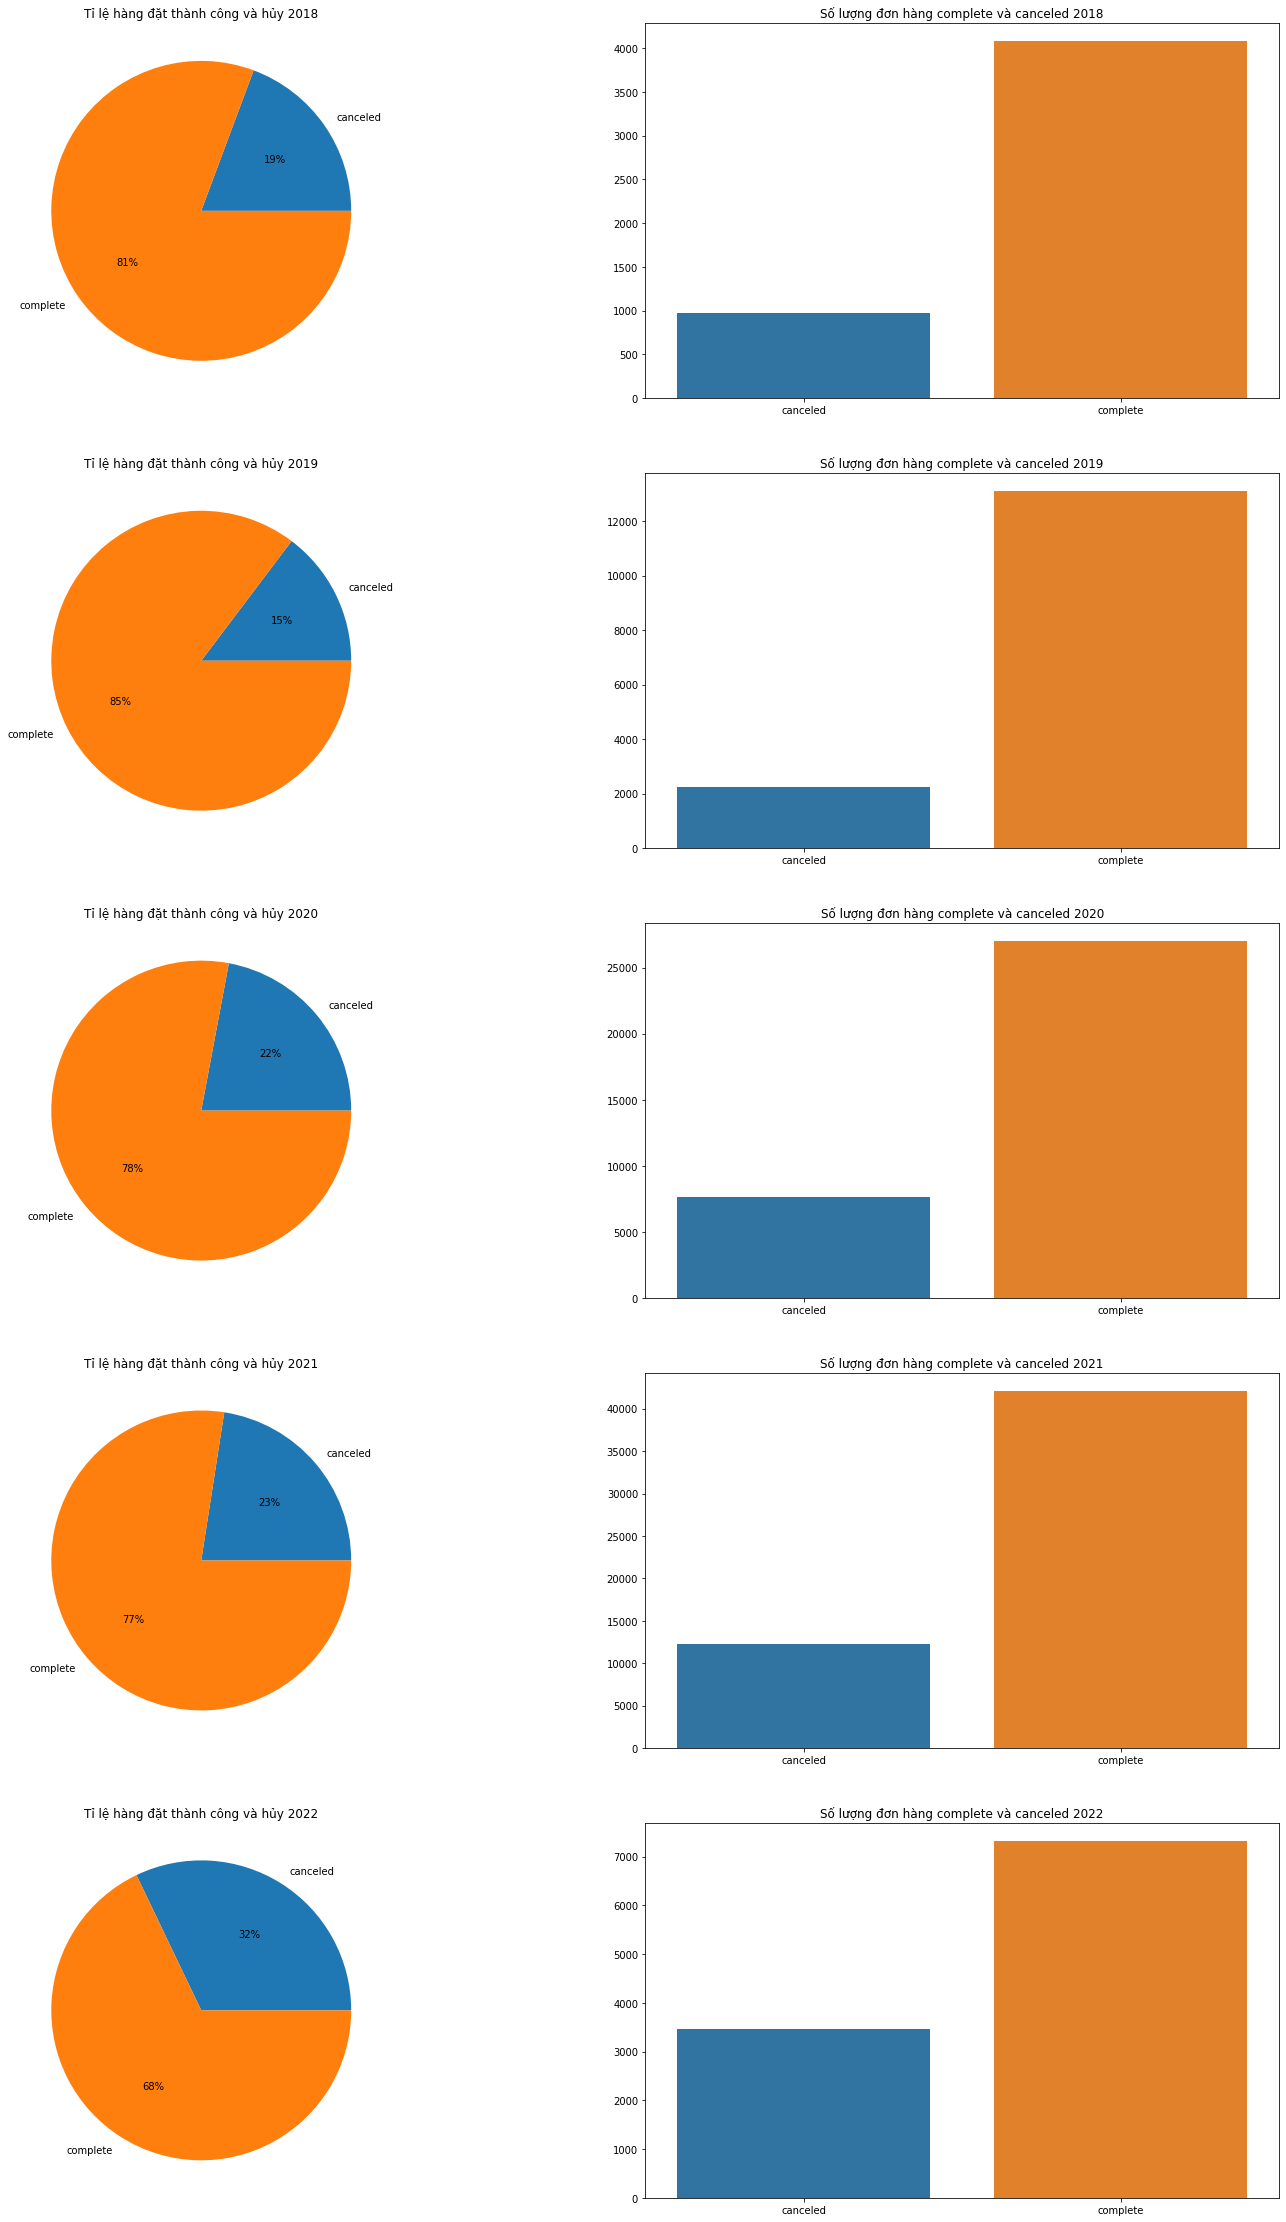

In [20]:
fig, ax = plt.subplots(5, 2, figsize = (25, 40))

for index, df in enumerate(fhs_sales_flat_order_item_state_list):
          df = \
                    df\
                              .loc[(df['fhs_sales_flat_order.state'].isin(['complete', 'canceled']))
                              &    (df['fhs_sales_flat_order.status'].isin(['complete', 'canceled']))]

          df = df  \
                    .groupby(['fhs_sales_flat_order.state'])\
                              ['fhs_sales_flat_order.entity_id'].count()
          df.plot.pie(x = 'fhs_sales_flat_order.state',
                              y = 'fhs_sales_flat_order.entity_id',ax = ax[index, 0], autopct='%1.0f%%')
          ax[index, 0].set_title(f'Tỉ lệ hàng đặt thành công và hủy {2018 + index}')
          ax[index, 0].set_xlabel('')
          ax[index, 0].set_ylabel('')

          df = df.reset_index()
          sns.barplot(data = df, y = 'fhs_sales_flat_order.entity_id',
                    x = 'fhs_sales_flat_order.state', ax = ax[index, 1])
          ax[index, 1].set_title(f'Số lượng đơn hàng complete và canceled {2018 + index}')
          ax[index, 1].set_xlabel('')
          ax[index, 1].set_ylabel('')
          

          


- Lưu lại biến canceled để xí phân tích

- Xử lí với các đơn complete

In [21]:
fhs_sales_flat_order_item_state_2022 = \
          fhs_sales_flat_order_item_state_2022\
                    .loc[(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.status'].isin(['complete']))]

fhs_sales_flat_order_item_state_2021 = \
          fhs_sales_flat_order_item_state_2021\
                    .loc[(fhs_sales_flat_order_item_state_2021['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2021['fhs_sales_flat_order.status'].isin(['complete']))]

fhs_sales_flat_order_item_state_2020 = \
          fhs_sales_flat_order_item_state_2020\
                    .loc[(fhs_sales_flat_order_item_state_2020['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2020['fhs_sales_flat_order.status'].isin(['complete']))]

fhs_sales_flat_order_item_state_2019 = \
          fhs_sales_flat_order_item_state_2019\
                    .loc[(fhs_sales_flat_order_item_state_2019['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2019['fhs_sales_flat_order.status'].isin(['complete']))]


fhs_sales_flat_order_item_state_2018 = \
          fhs_sales_flat_order_item_state_2018\
                    .loc[(fhs_sales_flat_order_item_state_2018['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2018['fhs_sales_flat_order.status'].isin(['complete']))]

In [22]:
fhs_sales_flat_order_item_state_list = [fhs_sales_flat_order_item_state_2018, fhs_sales_flat_order_item_state_2019, fhs_sales_flat_order_item_state_2020, 
          fhs_sales_flat_order_item_state_2021, fhs_sales_flat_order_item_state_2022]

In [23]:
for i in fhs_sales_flat_order_item_state_list:
          print(len(i))

4076
13102
27008
42101
7326


- So sánh giữa lượng mua hàng của loại hàng flashsale trong ngày flashsale và trong thời gian flashsale

In [24]:
def show_mean_count_product_month_dayofweek(index, ax):
          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
                    .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()

          # reset index đưa về dataframe
          df = df.reset_index()
          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          sns.boxplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.month,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax, palette="tab10")
          ax.set_ylabel('Số lượng')
          ax.set_title(f'Lượng hàng trung bình trong ngày theo tháng năm {2018 + index}')
          ax.set_xlabel('Các tháng trong năm')

def show_mean_count_product_per_sku_month_dayofweek(index, ax):
          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
                    .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()

          # reset index đưa về dataframe
          df = df.reset_index()
          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          sns.boxplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax, palette="tab10")
          ax.set_ylabel('Số lượng')
          ax.set_title(f'Lượng hàng trung bình trong ngày năm {2018 + index}')
          ax.set_xlabel('Các thứ trong tuần')                

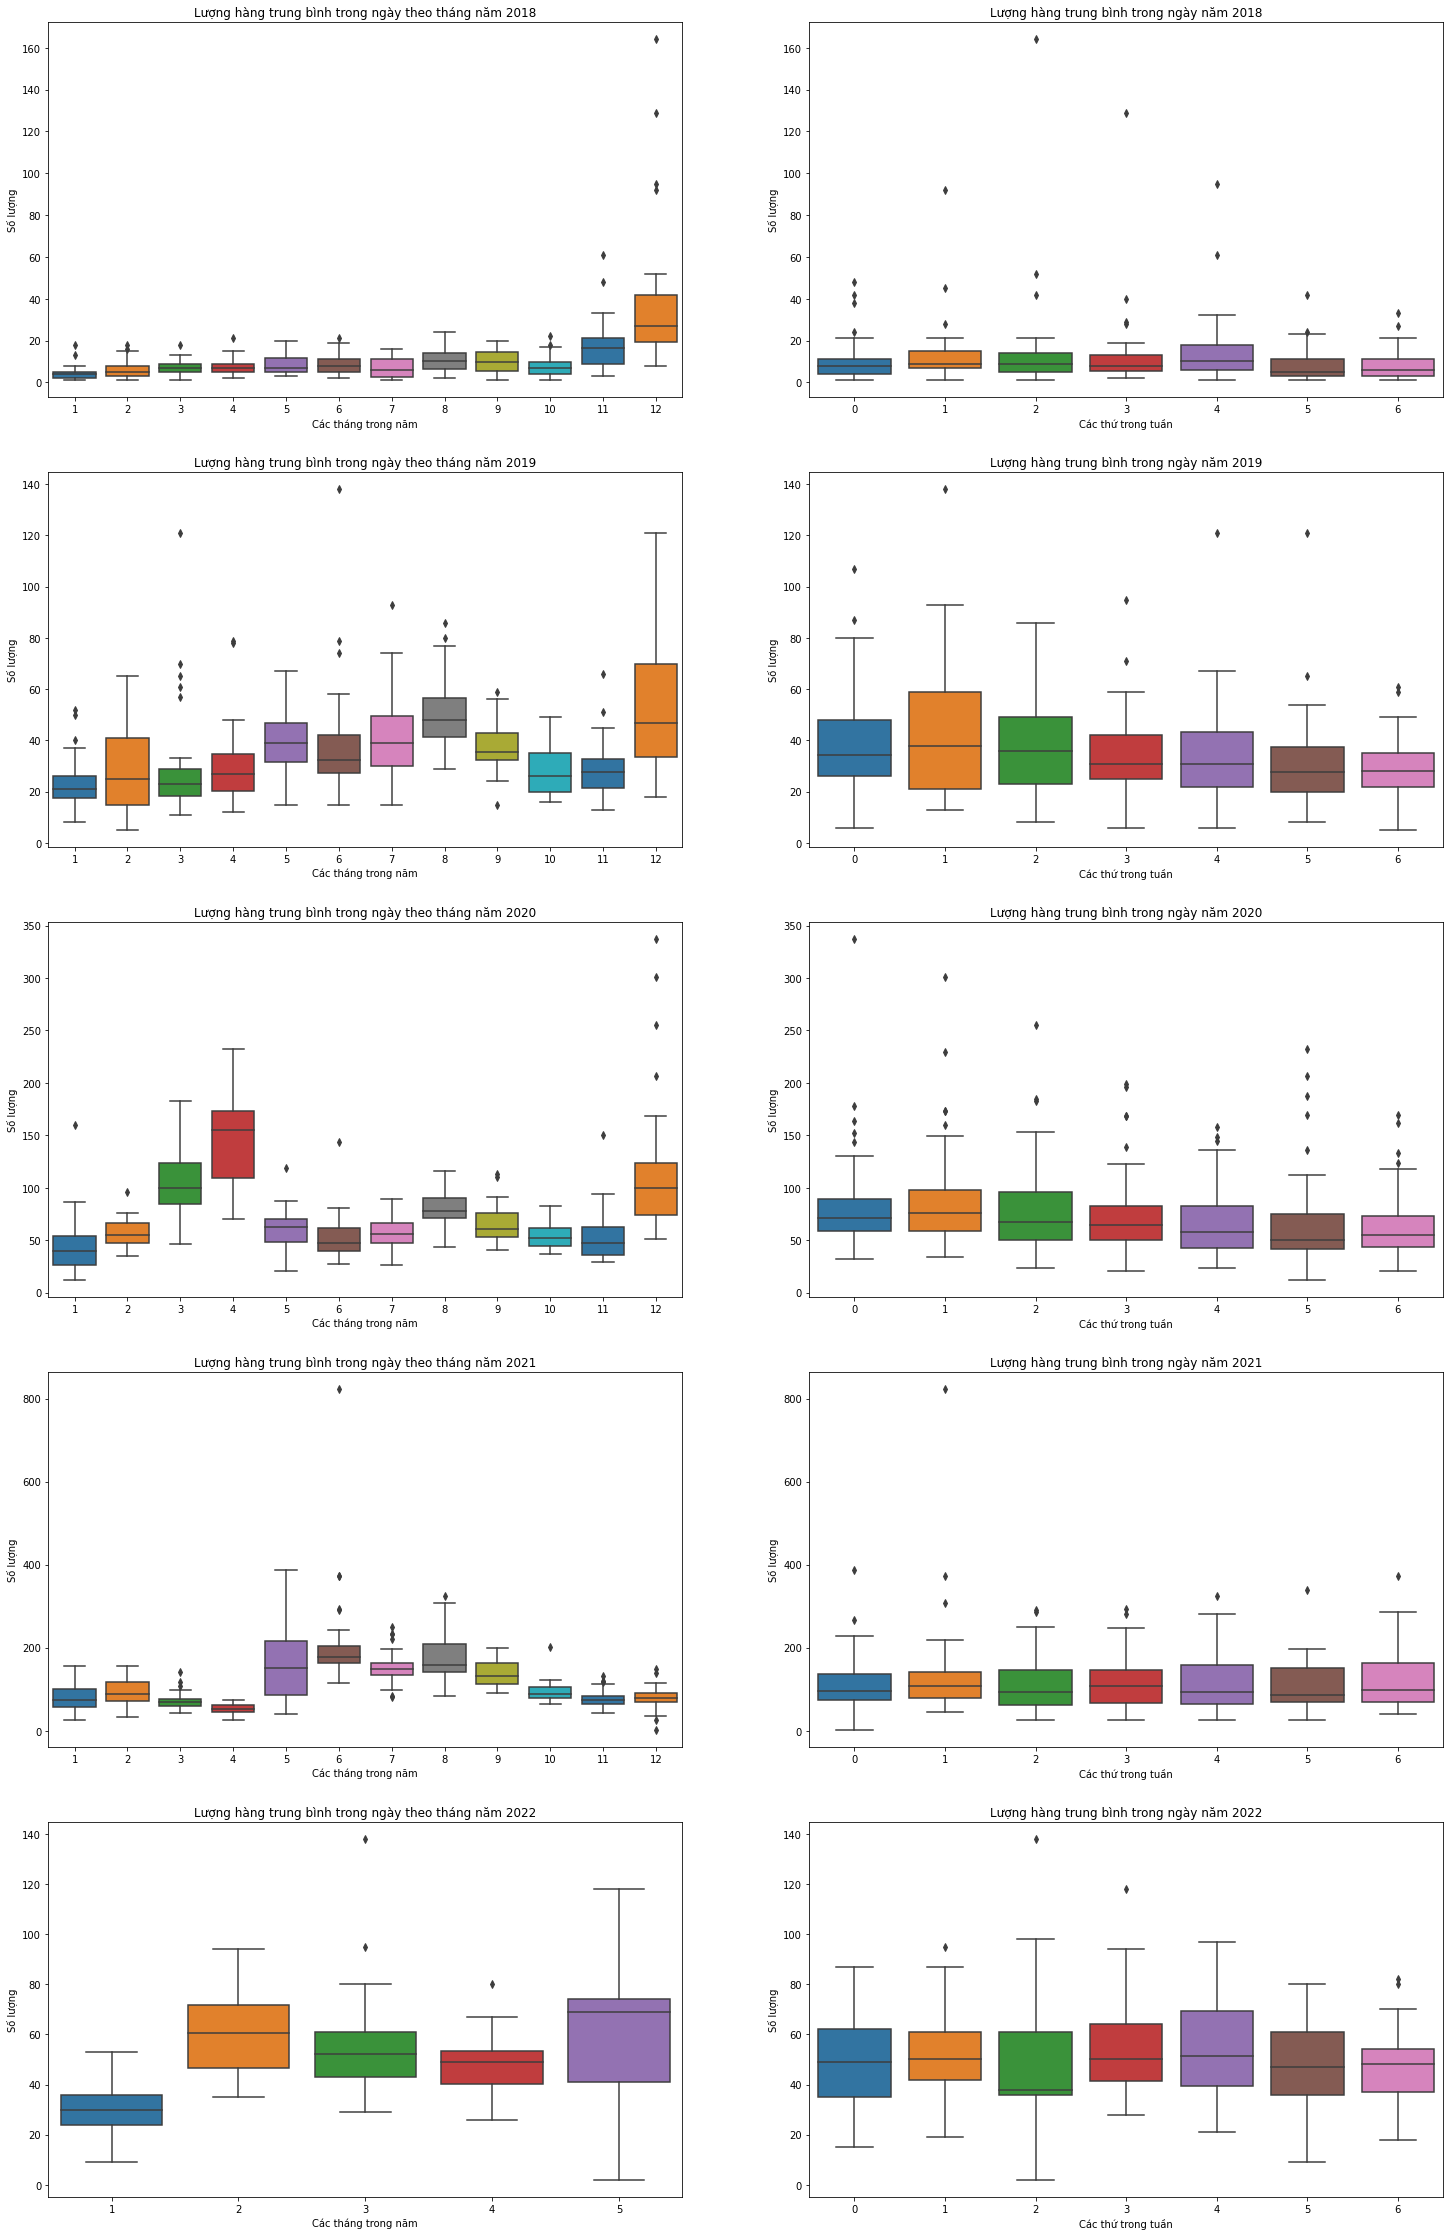

In [25]:
fig, ax = plt.subplots(5, 2, figsize=(25,40))
show_mean_count_product_month_dayofweek(0, ax[0, 0])
show_mean_count_product_month_dayofweek(1, ax[1, 0])
show_mean_count_product_month_dayofweek(2, ax[2, 0])
show_mean_count_product_month_dayofweek(3, ax[3, 0])
show_mean_count_product_month_dayofweek(4, ax[4, 0])

show_mean_count_product_per_sku_month_dayofweek(0, ax[0, 1])
show_mean_count_product_per_sku_month_dayofweek(1, ax[1, 1])
show_mean_count_product_per_sku_month_dayofweek(2, ax[2, 1])
show_mean_count_product_per_sku_month_dayofweek(3, ax[3, 1])
show_mean_count_product_per_sku_month_dayofweek(4, ax[4, 1])

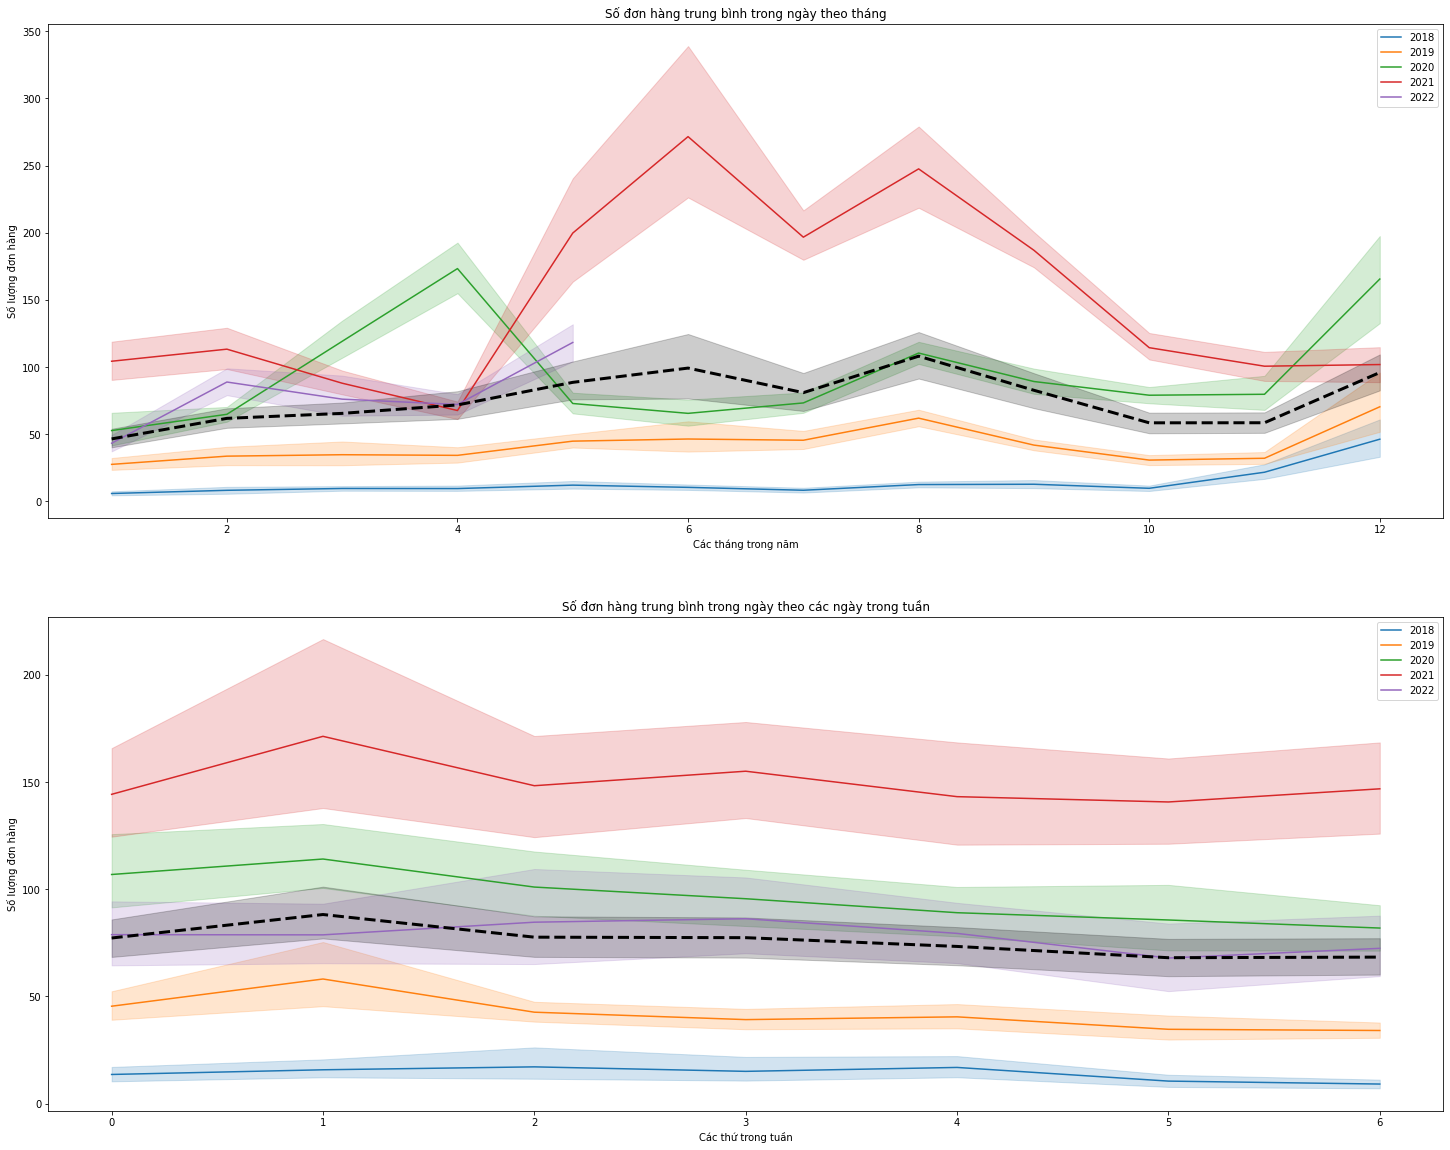

In [26]:
fig, ax = plt.subplots(2,1, figsize = (25, 20))

# vẽ đường trung bình
df = fhs_sales_flat_order_item_state_2018_2022         \
                    .groupby([fhs_sales_flat_order_item_state_2018_2022['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.month,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[0],
                    hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10")
sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.month,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[0], palette="tab10", linewidth = 3, color = 'black', linestyle='--')

ax[0].set_title('Số đơn hàng trung bình trong ngày theo tháng')
ax[0].set_xlabel('Các tháng trong năm')
ax[0].set_ylabel('Số lượng đơn hàng')


# vẽ đường trung bình
df = fhs_sales_flat_order_item_state_2018_2022         \
                    .groupby([fhs_sales_flat_order_item_state_2018_2022['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[1],
                    hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10")
sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[1], palette="tab10", linewidth = 3, color = 'black', linestyle='--')

ax[1].set_title('Số đơn hàng trung bình trong ngày theo các ngày trong tuần')
ax[1].set_xlabel('Các thứ trong tuần')
ax[1].set_ylabel('Số lượng đơn hàng')

for container in ax[1].containers:
    ax[1].bar_label(container, label_type='edge')

In [27]:
def show_sum_month_in_year(index, ax1, ax2):
          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
                    .groupby([df['fhs_sales_flat_order_item.created_at'].dt.month])\
                              ['fhs_sales_flat_order.entity_id'].count()

          def autopct(pct): # only show the label when it's > 10%
                    return ('%.2f' % pct) if pct > 5 else ''
          df.plot.pie(x = 'fhs_sales_flat_order_item.created_at', y = 'fhs_sales_flat_order.entity_id', ax = ax1, autopct = autopct)

          ax1.set_title(f'Phần trăm đơn hàng từng tháng trong năm {2018 + index}')
          ax1.set_ylabel('Các tháng trong năm')


          df = df.reset_index()

          sns.barplot(data = df, x = 'fhs_sales_flat_order_item.created_at', 
                    y = 'fhs_sales_flat_order.entity_id', ax = ax2)

          for container in ax2.containers:
                    labels = [f'{round(v.get_height())}' for i, v in enumerate(container)]
                    ax2.bar_label(container, label_type='edge', labels = labels)
          ax2.set_title(f'Tổng đơn hàng từng tháng trong năm {2018 + index}')
          ax2.set_xlabel('Các tháng trong năm')
          ax2.set_ylabel('Số đơn hàng')

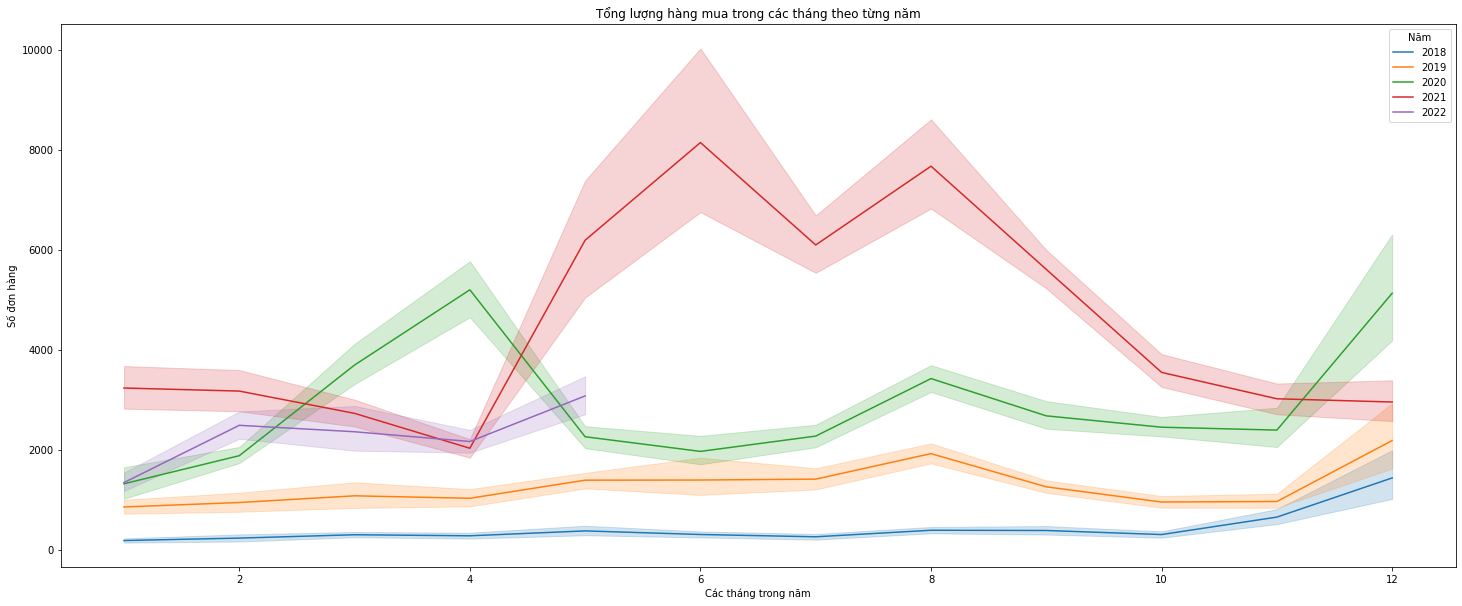

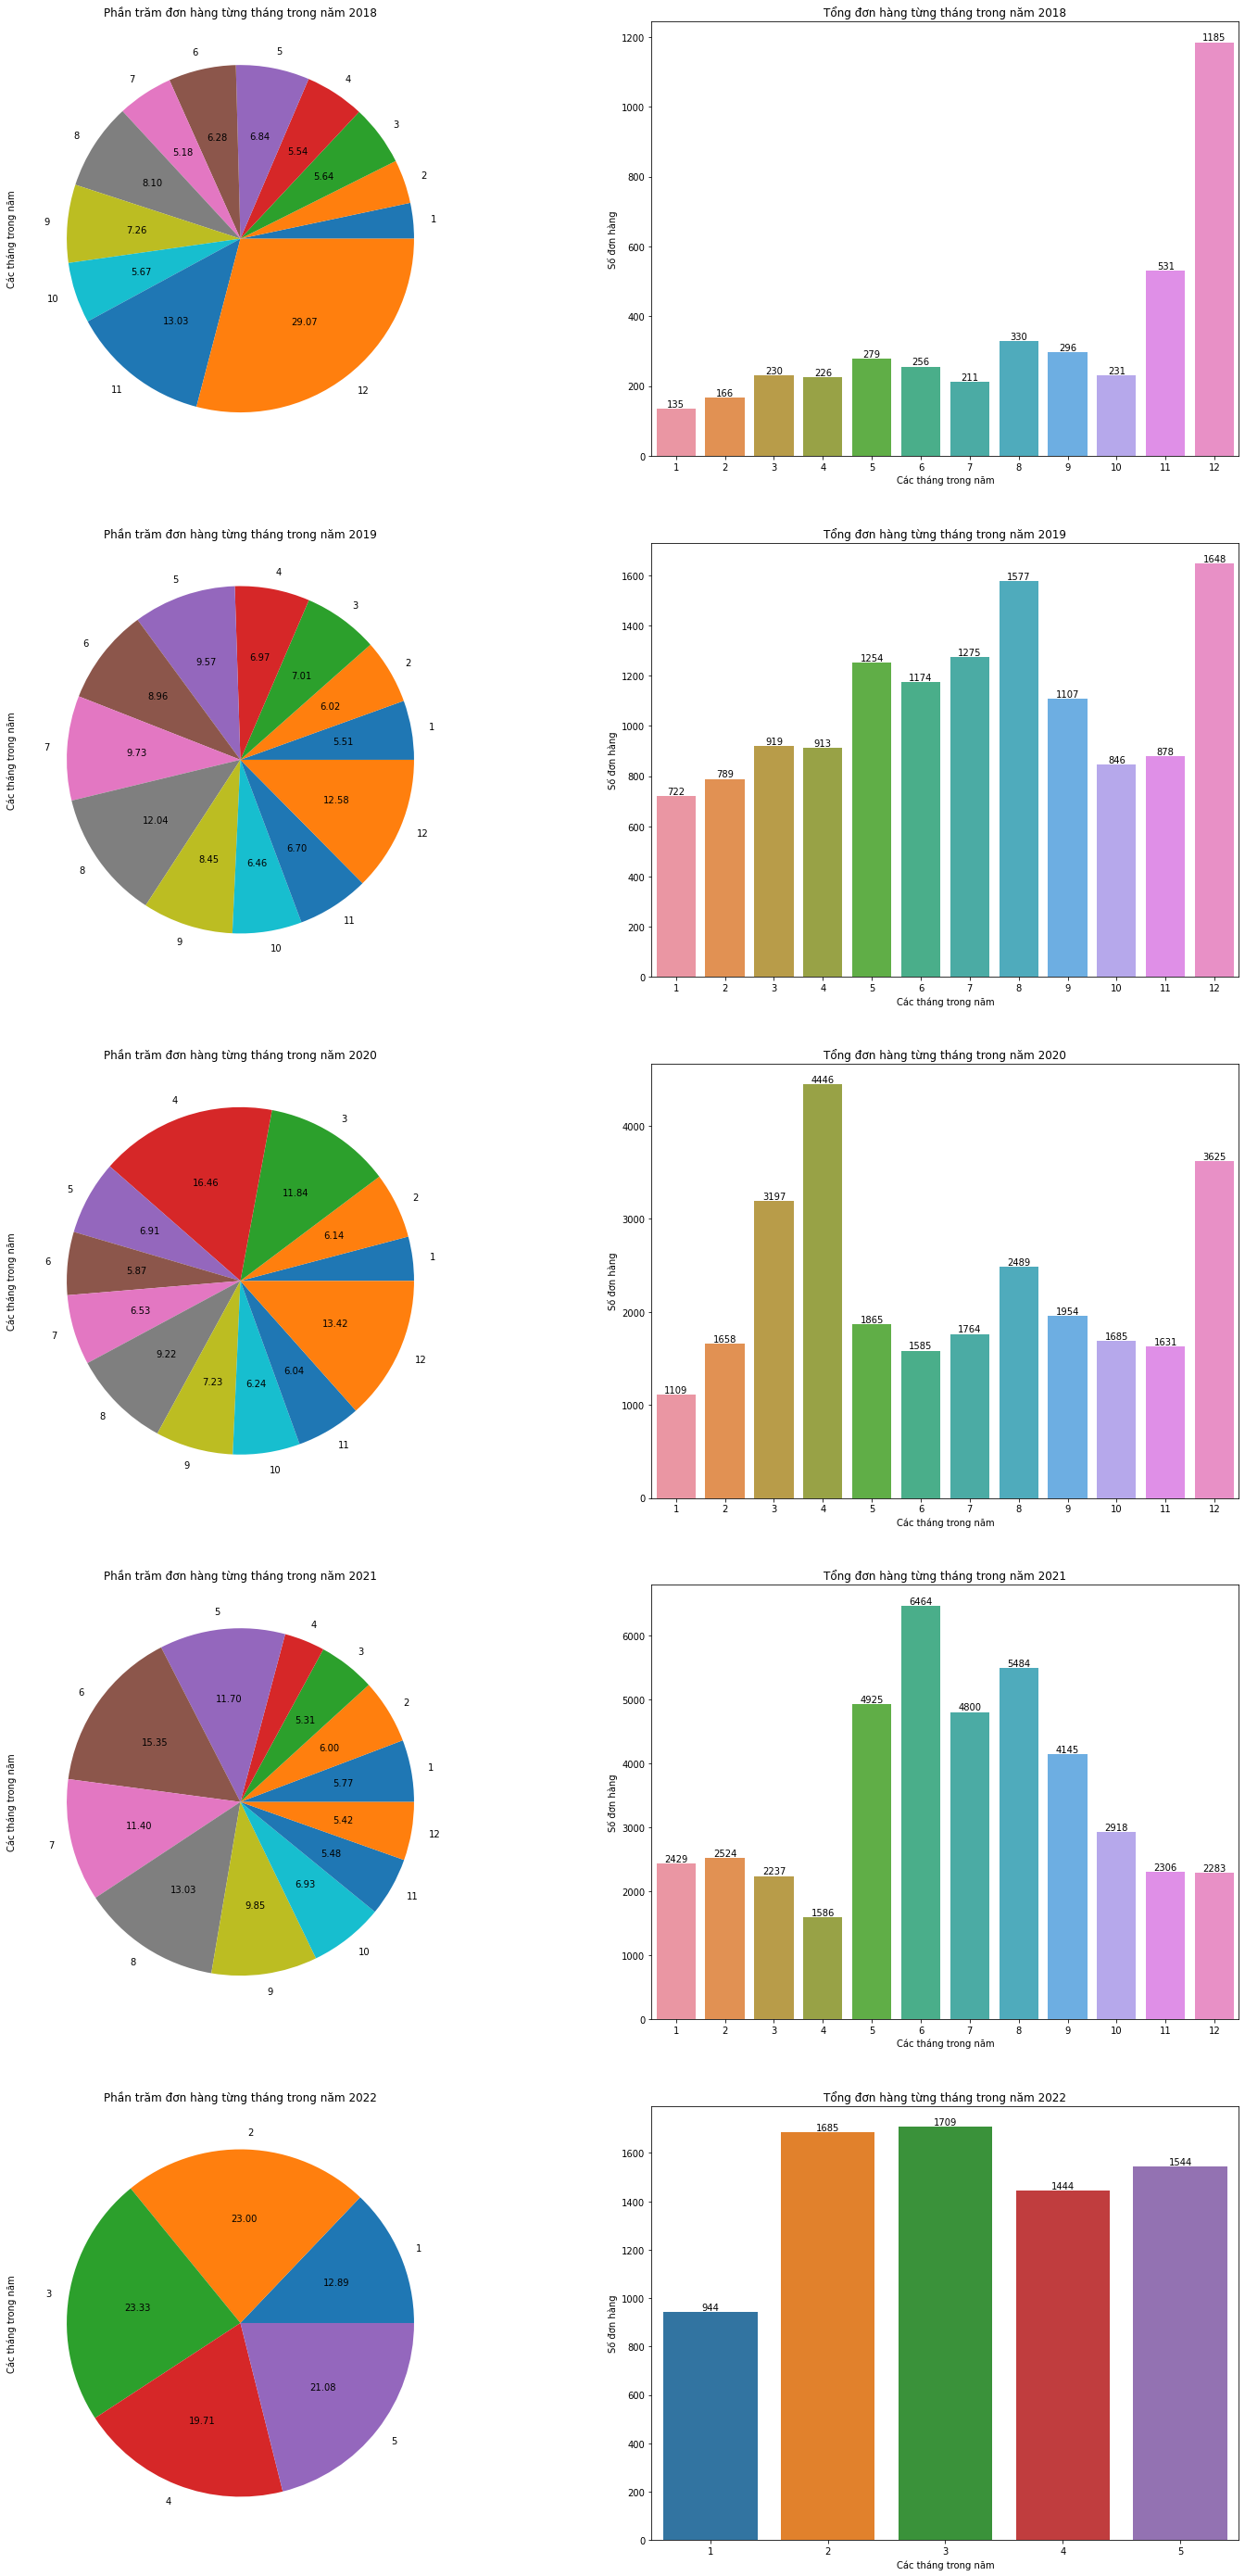

In [28]:
fig, ax = plt.subplots(1,1, figsize = (25, 10))

# vẽ đường trung bình
df = fhs_sales_flat_order_item_state_2018_2022         \
          .groupby([fhs_sales_flat_order_item_state_2018_2022['fhs_sales_flat_order_item.created_at'].dt.date])\
                    ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.month,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax,
                    hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10", estimator = np.sum)
ax.set_title('Tổng lượng hàng mua trong các tháng theo từng năm')
ax.legend(title = 'Năm')
ax.set_xlabel('Các tháng trong năm')
ax.set_ylabel('Số đơn hàng')

fig, ax = plt.subplots(5,2, figsize = (25, 50))

show_sum_month_in_year(0, ax[0,0], ax[0,1])
show_sum_month_in_year(1, ax[1,0], ax[1,1])
show_sum_month_in_year(2, ax[2,0], ax[2,1])
show_sum_month_in_year(3, ax[3,0], ax[3,1])
show_sum_month_in_year(4, ax[4,0], ax[4,1])


In [29]:
def show_sum_quarter_in_year(index, ax1, ax2):
          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
                    .groupby([df['fhs_sales_flat_order_item.created_at'].dt.quarter])\
                              ['fhs_sales_flat_order.entity_id'].count()

          def autopct(pct): # only show the label when it's > 10%
                    return ('%.2f' % pct) if pct > 5 else ''
          df.plot.pie(x = 'fhs_sales_flat_order_item.created_at', y = 'fhs_sales_flat_order.entity_id', ax = ax1, autopct = autopct)

          ax1.set_title(f'Phần trăm đơn hàng từng quý trong năm {2018 + index}')
          ax1.set_ylabel('Các quý trong năm')


          df = df.reset_index()

          sns.barplot(data = df, x = 'fhs_sales_flat_order_item.created_at', 
                    y = 'fhs_sales_flat_order.entity_id', ax = ax2)

          for container in ax2.containers:
                    labels = [f'{round(v.get_height())}' for i, v in enumerate(container)]
                    ax2.bar_label(container, label_type='edge', labels = labels)
          ax2.set_title(f'Tổng đơn hàng từng quý trong năm {2018 + index}')
          ax2.set_xlabel('Các quý trong năm')
          ax2.set_ylabel('Số đơn hàng')

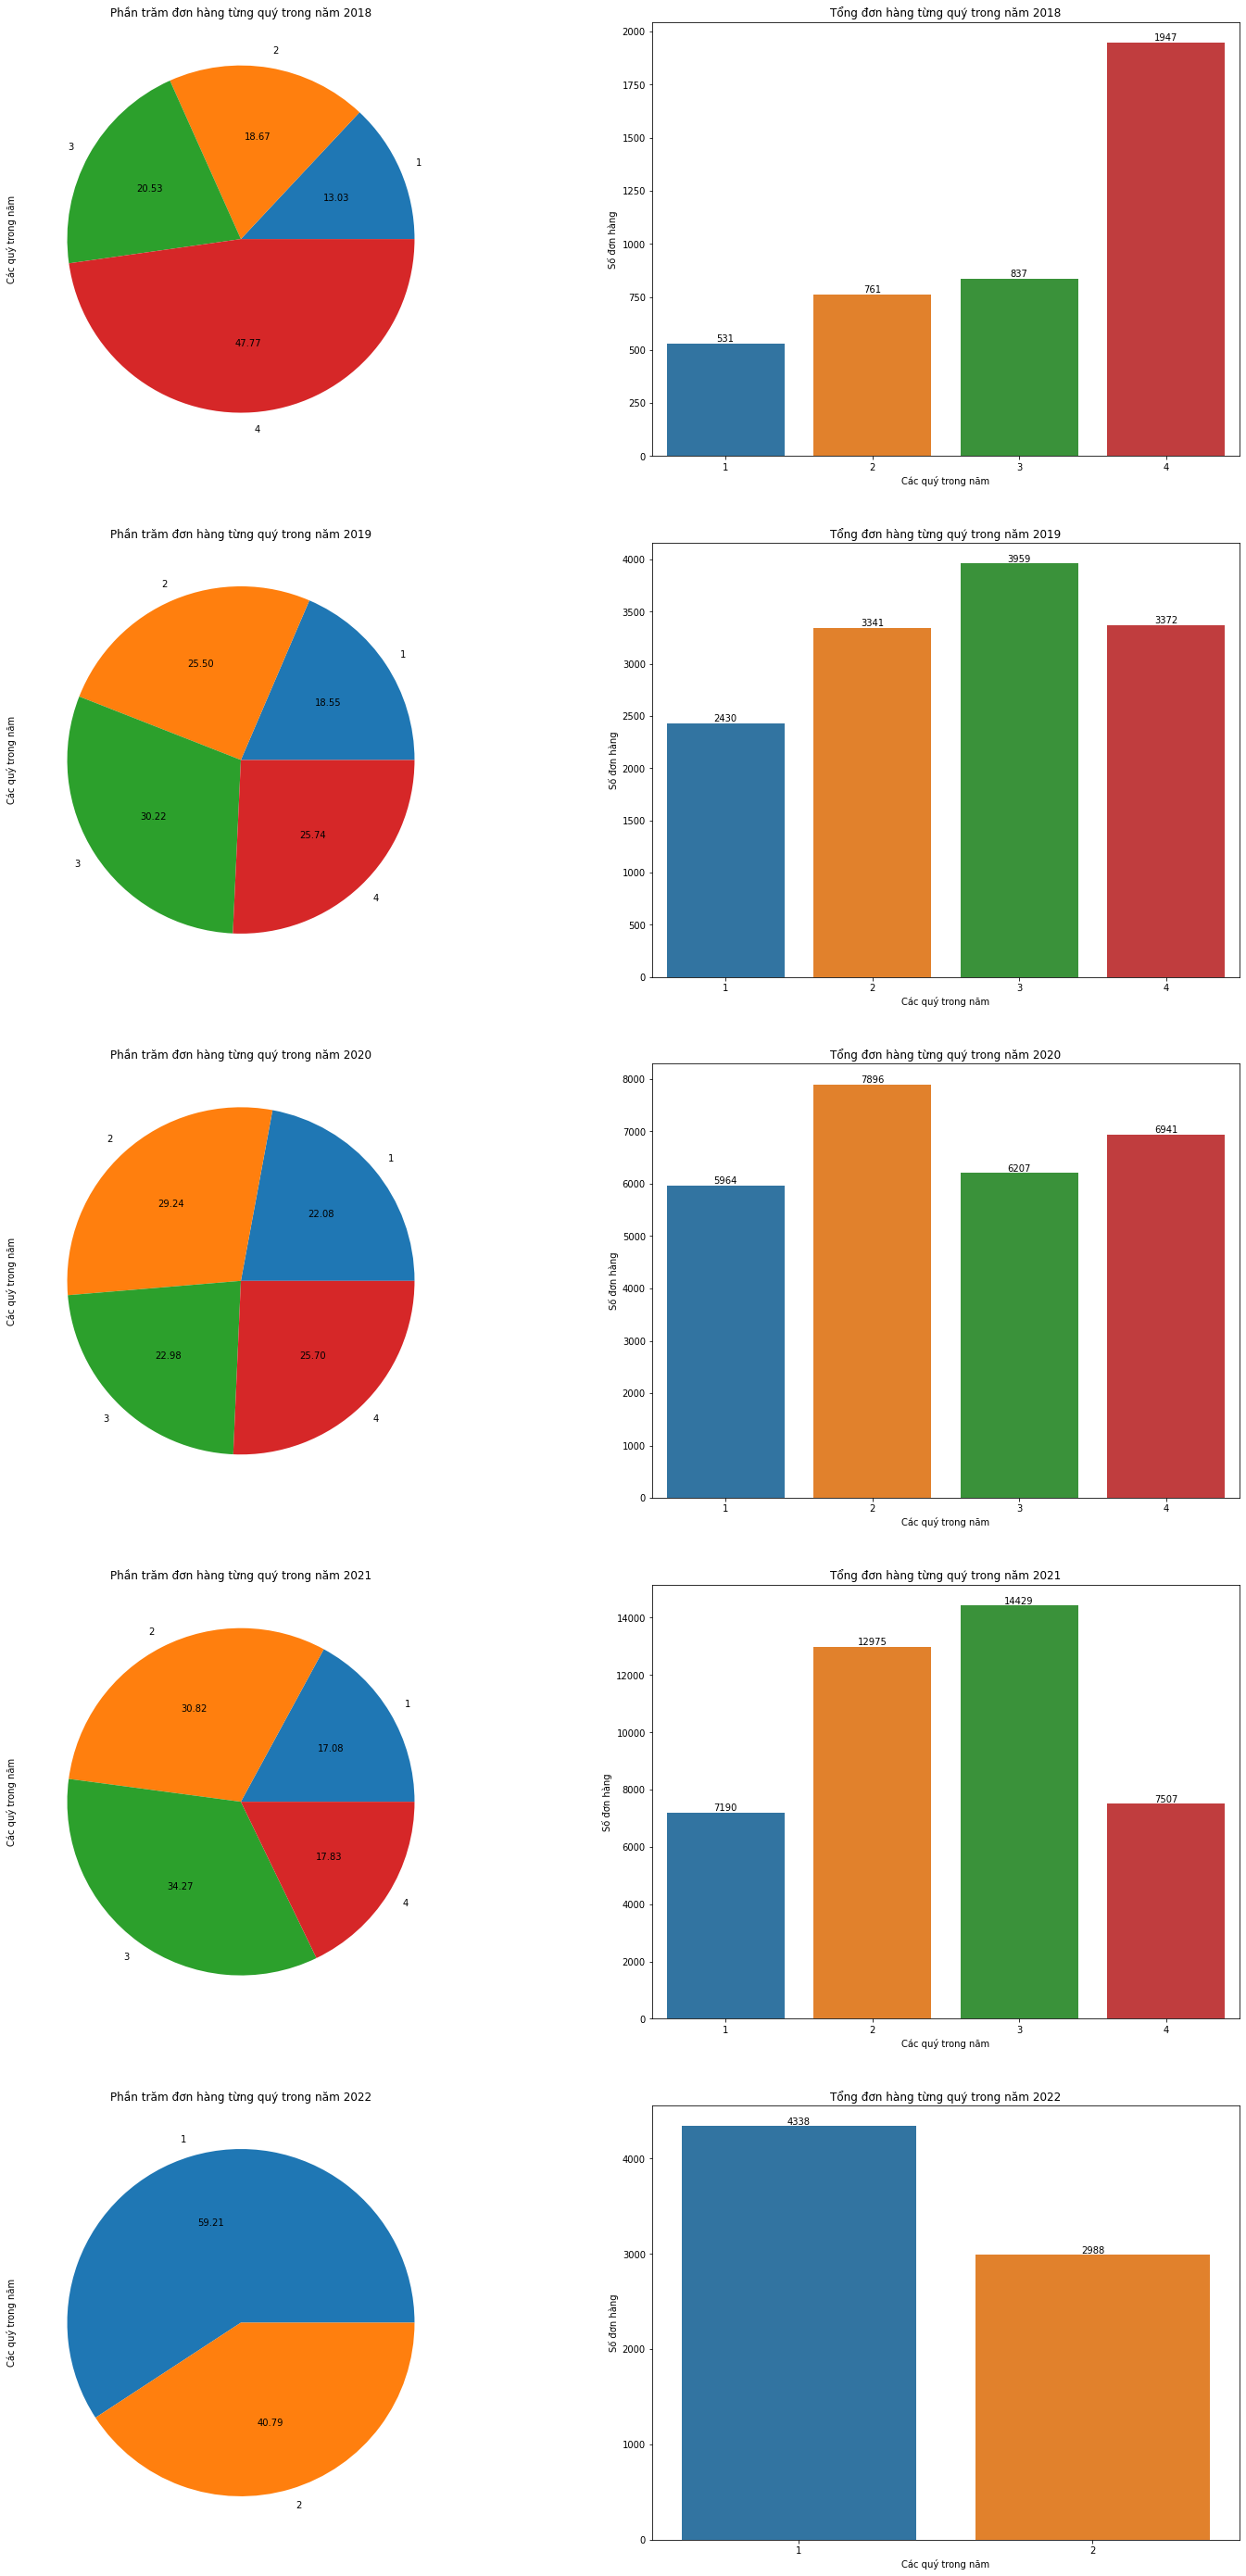

In [30]:
fig, ax = plt.subplots(5,2, figsize = (25, 50))

show_sum_quarter_in_year(0, ax[0,0], ax[0,1])
show_sum_quarter_in_year(1, ax[1,0], ax[1,1])
show_sum_quarter_in_year(2, ax[2,0], ax[2,1])
show_sum_quarter_in_year(3, ax[3,0], ax[3,1])
show_sum_quarter_in_year(4, ax[4,0], ax[4,1])

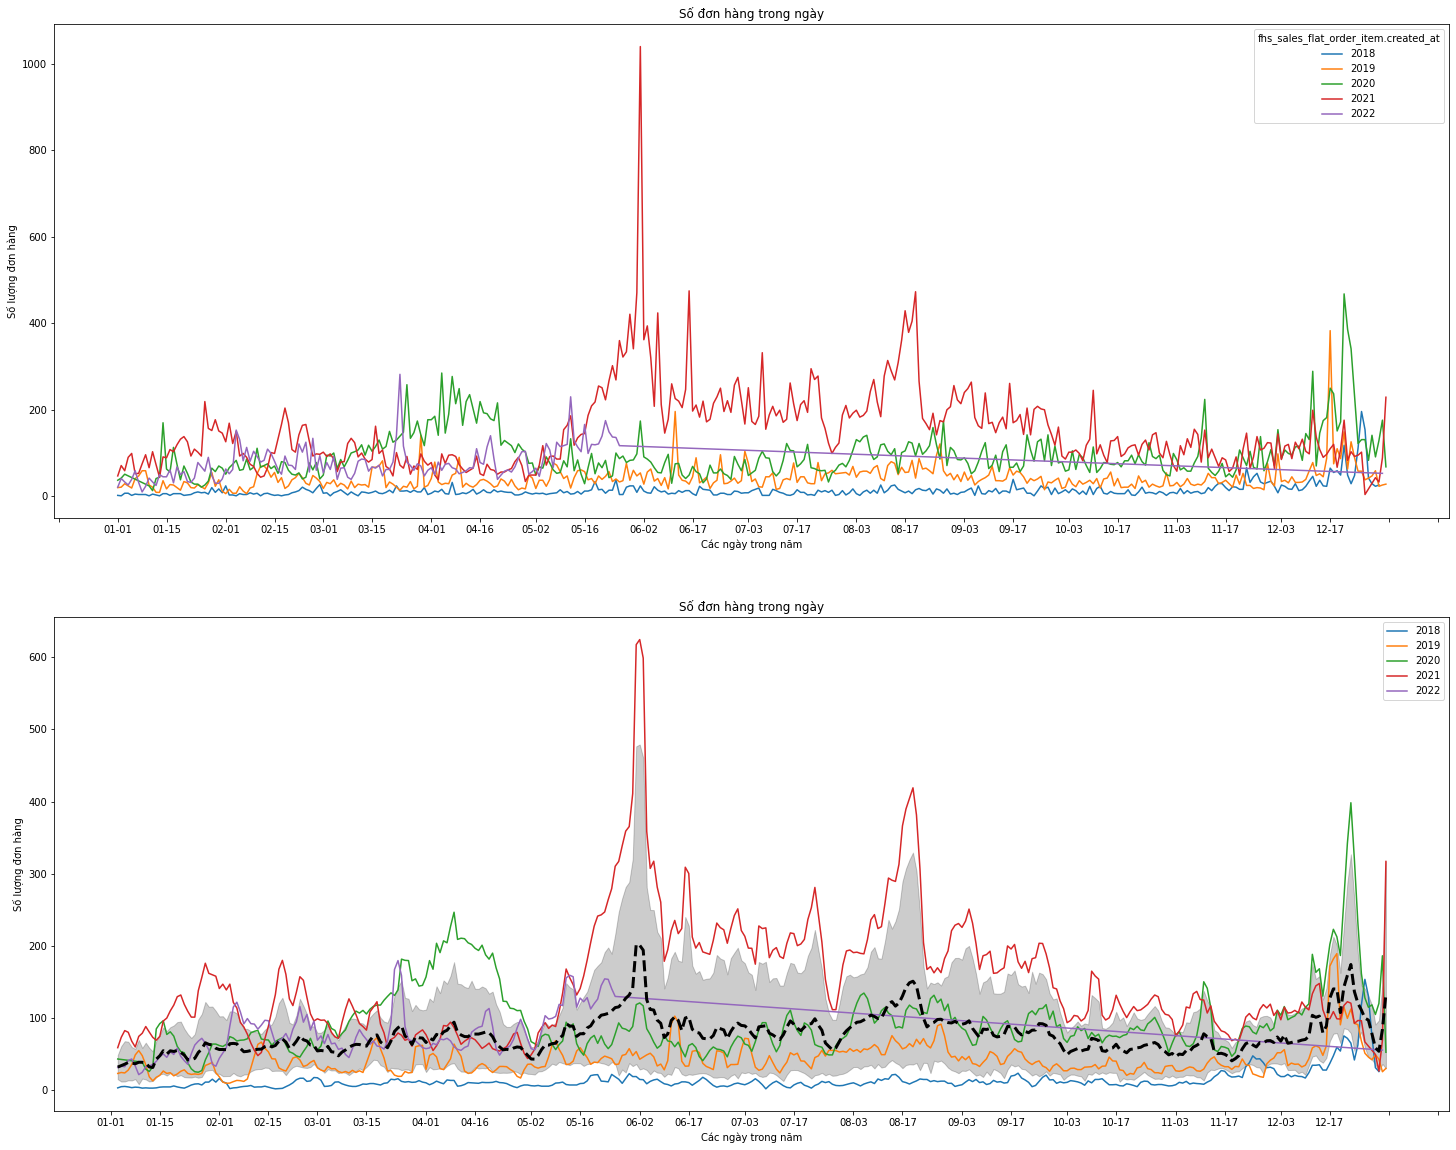

In [31]:


fig, ax = plt.subplots(2,1, figsize = (25, 20))

# vẽ đường trung bình
df = fhs_sales_flat_order_item_state_2018_2022         \
                    .groupby([fhs_sales_flat_order_item_state_2018_2022['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
df = df.loc[~(df['fhs_sales_flat_order_item.created_at'].dt.month.eq(2) & df['fhs_sales_flat_order_item.created_at'].dt.day.eq(29))] 

sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.strftime('%m-%d'),
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[0],
                    hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10")


ax[0].set_title('Số đơn hàng trong ngày')
ax[0].set_xlabel('Các ngày trong năm')
ax[0].set_ylabel('Số lượng đơn hàng')
ax[0].xaxis.set_major_locator(mdates.DayLocator((1,15)))

df = df.sort_values('fhs_sales_flat_order_item.created_at')

df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2018, 'fhs_sales_flat_order.entity_id'] \
          = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2018]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2019, 'fhs_sales_flat_order.entity_id'] \
          = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2019]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2020, 'fhs_sales_flat_order.entity_id'] \
          = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2020]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2021, 'fhs_sales_flat_order.entity_id'] \
          = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2021]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2022, 'fhs_sales_flat_order.entity_id'] \
          = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2022]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.strftime('%m-%d'),
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[1],
                    hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10", alpha  =1)

sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.strftime('%m-%d'),
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[1], palette="tab10", linewidth = 3, color = 'black', linestyle='--')

ax[1].set_title('Số đơn hàng trong ngày')
ax[1].set_xlabel('Các ngày trong năm')
ax[1].set_ylabel('Số lượng đơn hàng')
ax[1].xaxis.set_major_locator(mdates.DayLocator((1,15)))


In [32]:
def show_line_count_product_dayinmonth(index, ax1, ax2):

          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
                    .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()
          
          # reset index đưa về dataframe
          df = df.reset_index()
          
          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax1,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.month, palette="tab10")

          ax1.set_title(f'Đơn hàng theo ngày vào các tháng năm {2018 + index}')
          ax1.legend(title = 'Tháng')
          ax1.set_xlabel('Ngày trong tháng')
          ax1.set_ylabel('Số đơn hàng')
          

          df = df.sort_values('fhs_sales_flat_order_item.created_at')
          df['fhs_sales_flat_order.entity_id'] \
                    = df['fhs_sales_flat_order.entity_id'].rolling(3).mean()

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax2,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.month, palette="tab10")
                    
          sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax2, linewidth = 3, color = 'black', linestyle='--')

          ax2.set_title(f'Moving Average lượng hàng hóa năm {2018 + index}')
          ax2.legend(title = 'Tháng')
          ax2.set_xlabel('Ngày trong tháng')
          ax2.set_ylabel('Số đơn hàng')


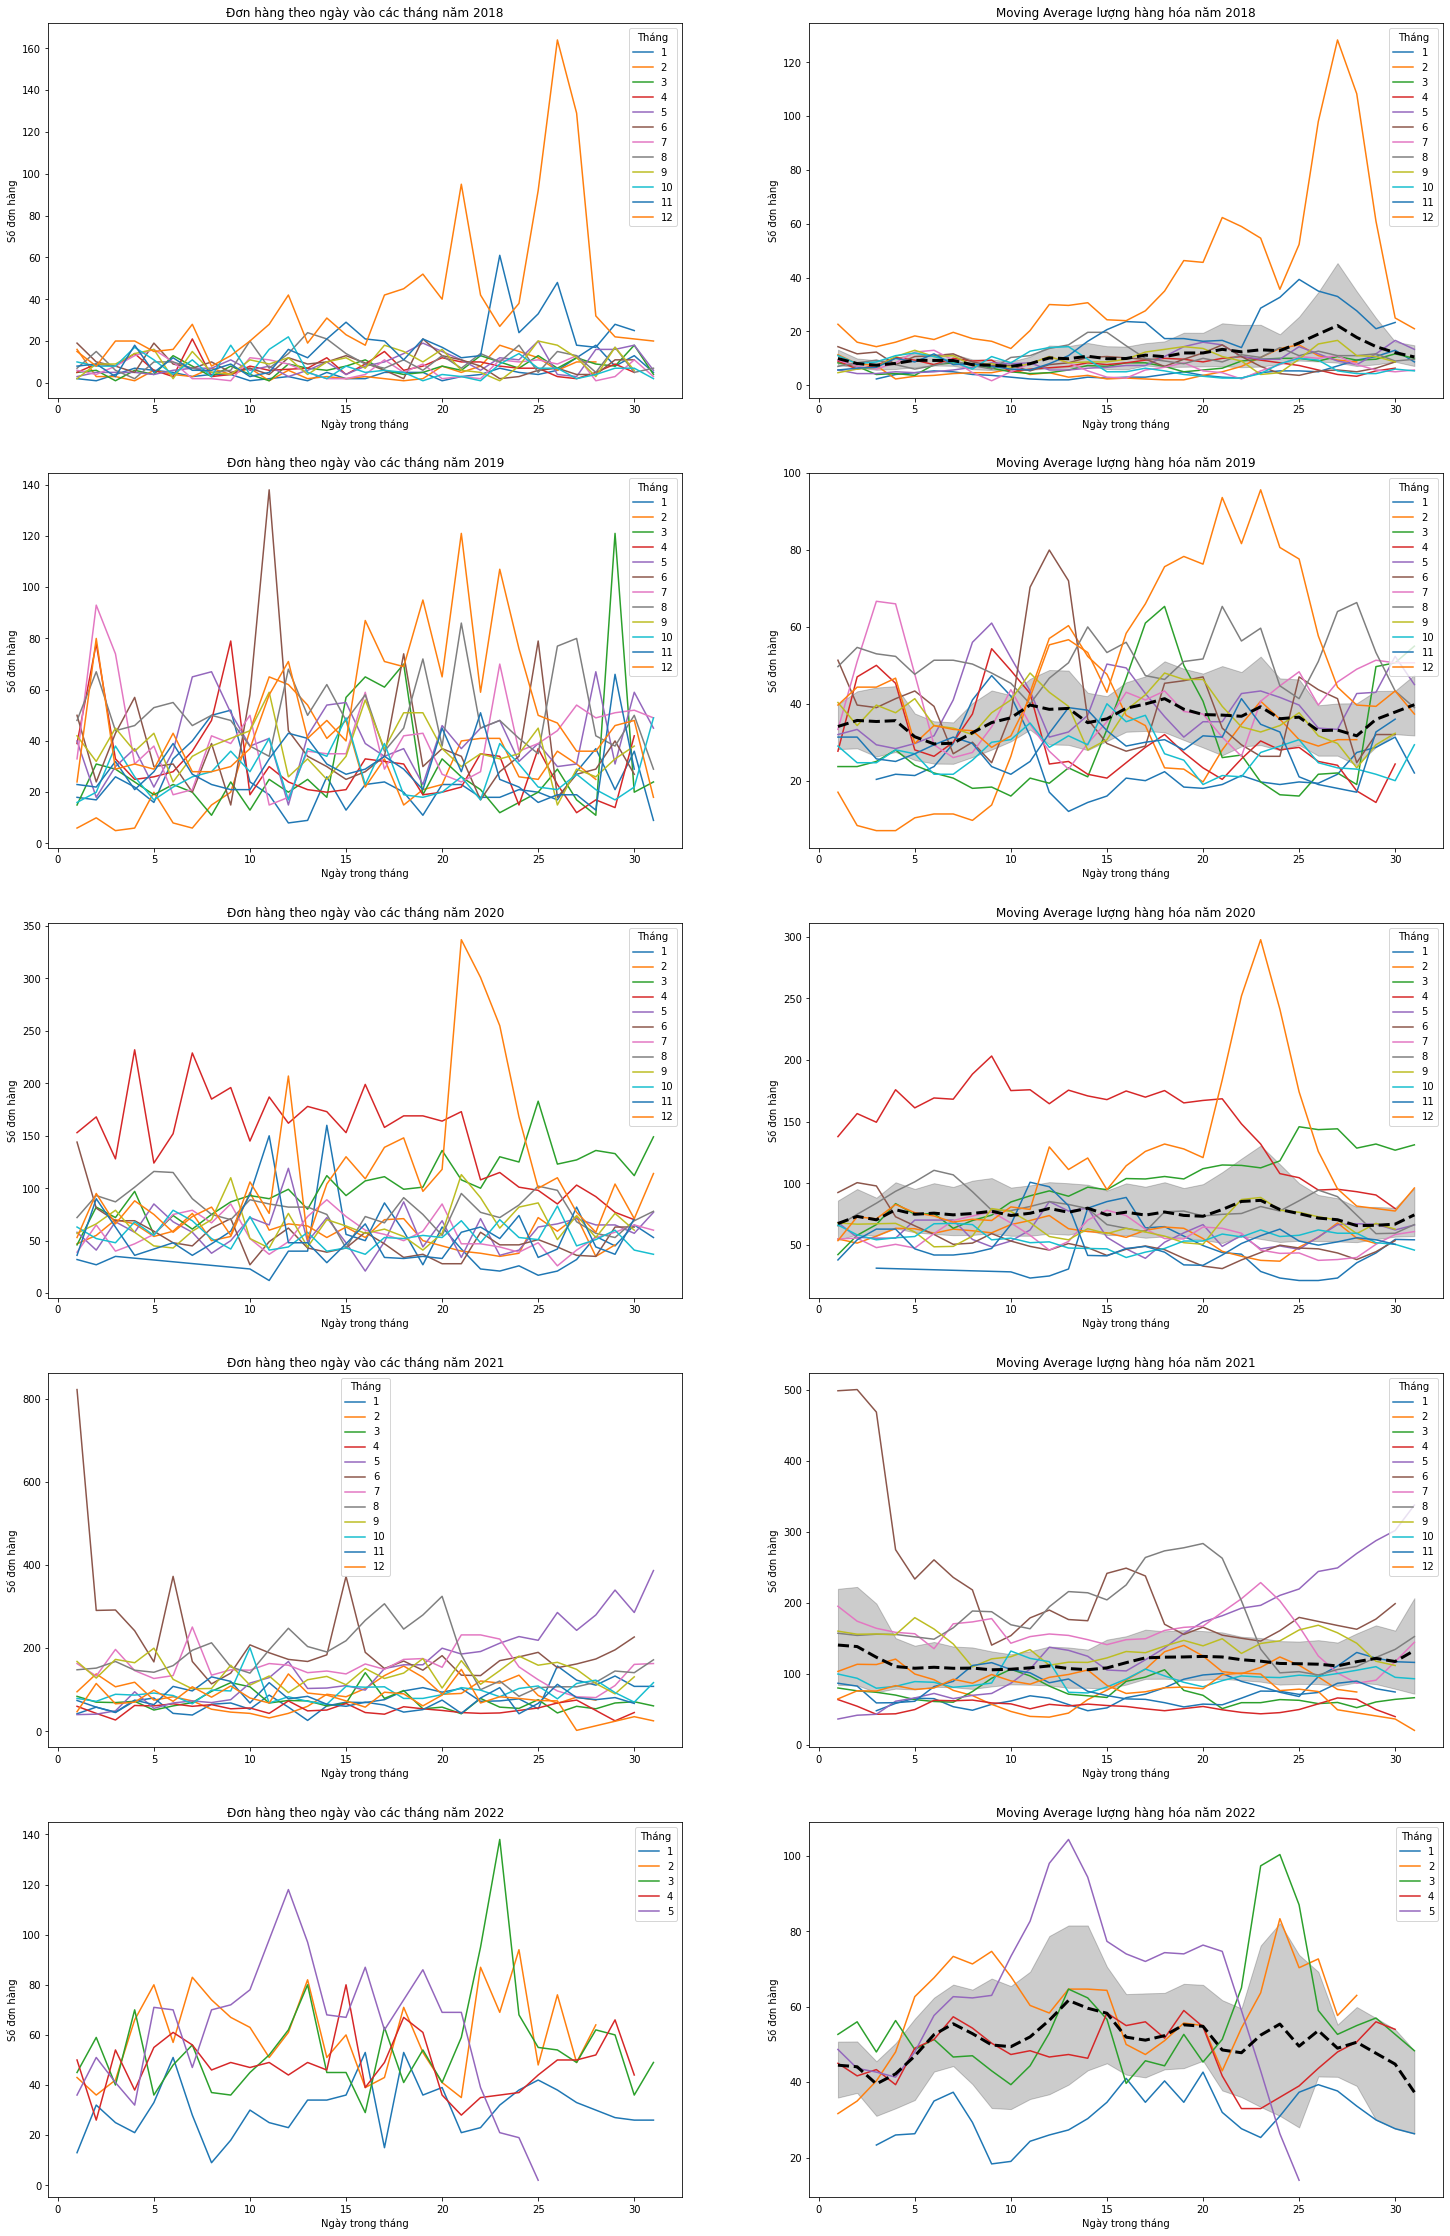

In [33]:
fig, ax = plt.subplots(5,2, figsize = (25, 40))
show_line_count_product_dayinmonth(0, ax[0, 0], ax[0, 1])
show_line_count_product_dayinmonth(1, ax[1, 0], ax[1, 1])
show_line_count_product_dayinmonth(2, ax[2, 0], ax[2, 1])
show_line_count_product_dayinmonth(3, ax[3, 0], ax[3, 1])
show_line_count_product_dayinmonth(4, ax[4, 0], ax[4, 1])

In [34]:
def show_line_count_product_month_every_year(month, ax1, ax2):
          df = fhs_sales_flat_order_item_state_2018_2022         \
                    .groupby([fhs_sales_flat_order_item_state_2018_2022['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()

          # reset index đưa về dataframe
          df = df.reset_index()

          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          df = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.month == month]
          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax1,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10")

          ax1.set_title(f'Đơn hàng tháng {month} vào các năm')
          ax1.legend(title = 'Năm')
          ax1.set_xlabel('Ngày trong tháng')
          ax1.set_ylabel('Số đơn hàng')


          df = df.sort_values('fhs_sales_flat_order_item.created_at')
          df['fhs_sales_flat_order.entity_id'] \
                    = df['fhs_sales_flat_order.entity_id'].rolling(3).mean()

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax2,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10")
          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax2, linewidth = 3, color = 'black', linestyle='--')

          ax2.set_title(f'Moving Average Đơn hàng tháng {month} vào các năm')
          ax2.legend(title = 'Năm')
          ax2.set_xlabel('Ngày trong tháng')
          ax2.set_ylabel('Số đơn hàng')

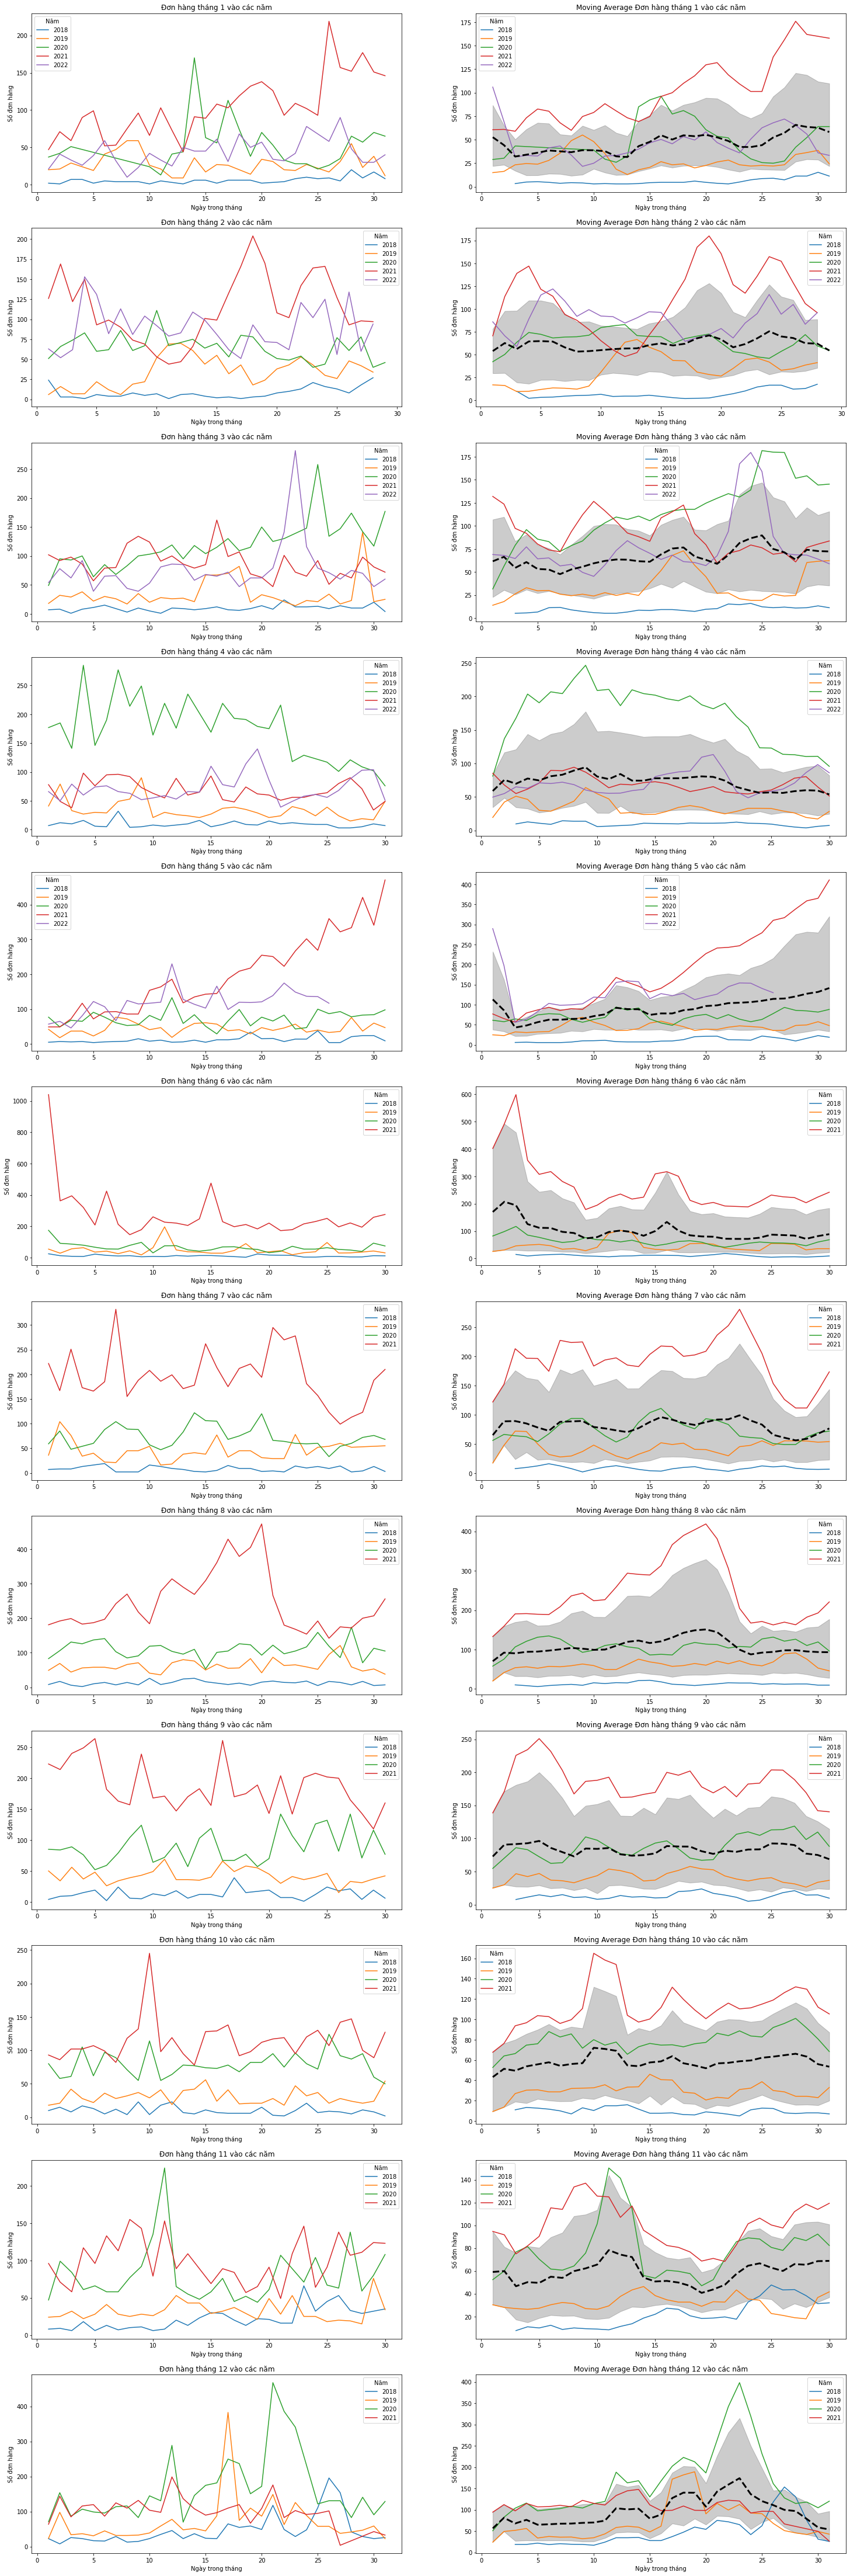

In [35]:
fig, ax = plt.subplots(12,2, figsize = (25, 80))

for i in range(1, 13):
          show_line_count_product_month_every_year(i, ax[i - 1, 0], ax[i - 1, 1])


In [36]:
def show_line_count_product_dayinweek(index, ax1, ax2):

          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
          .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date])\
                    ['fhs_sales_flat_order.entity_id'].count()

          # reset index đưa về dataframe
          df = df.reset_index()

          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax1,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.week, palette="tab10")

          ax1.set_title(f'Đơn hàng theo thứ trong tuần năm {2018 + index}')
          ax1.set_xlabel('Thứ trong tuần')
          ax1.set_ylabel('Số đơn hàng')
          ax1.get_legend().remove()
          ax1.set_xticks([0, 1, 2, 3, 4, 5, 6], ['MON','TUE','WED','THU  ','FRI','SAT','SUN'])

          
          df = df.groupby([df['fhs_sales_flat_order_item.created_at'].dt.week, df['fhs_sales_flat_order_item.created_at'].dt.dayofweek])\
                    ['fhs_sales_flat_order.entity_id'].aggregate('first').unstack()

          for thu in range(0, 6):
                    df = df[np.abs(stats.zscore(df[thu], nan_policy = 'omit')) < 2]
          df.index.name = 'fhs_sales_flat_order_item.created_at_week'
          df = df.stack().reset_index()

          df.columns = ['fhs_sales_flat_order_item.created_at_week', 'fhs_sales_flat_order_item.created_at_dayofweek', 'fhs_sales_flat_order.entity_id']

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at_dayofweek'],
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax2,
                              hue = df['fhs_sales_flat_order_item.created_at_week'], palette="tab10")
                    
          sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at_dayofweek'],
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax2, linewidth = 3, color = 'black', linestyle='--')

          ax2.set_title(f'Lượng hàng hóa năm {2018 + index}')
          ax2.set_xlabel('Thứ trong tuần')
          ax2.set_ylabel('Số đơn hàng')
          ax2.get_legend().remove()
          ax2.set_xticks([0, 1, 2, 3, 4, 5, 6], ['MON','TUE','WED','THU  ','FRI','SAT','SUN'])



/tmp/ipykernel_33323/14177349.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  hue = df['fhs_sales_flat_order_item.created_at'].dt.week, palette="tab10")
/tmp/ipykernel_33323/14177349.py:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df = df.groupby([df['fhs_sales_flat_order_item.created_at'].dt.week, df['fhs_sales_flat_order_item.created_at'].dt.dayofweek])\
/tmp/ipykernel_33323/14177349.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  hue = df['fhs_sales_flat_order_item.created_at'].dt.week, palette="tab10")
/tmp/ipykernel_33323/14177349.py:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df = df.groupby([df['fhs_sales_flat_order_item.created_at'].dt

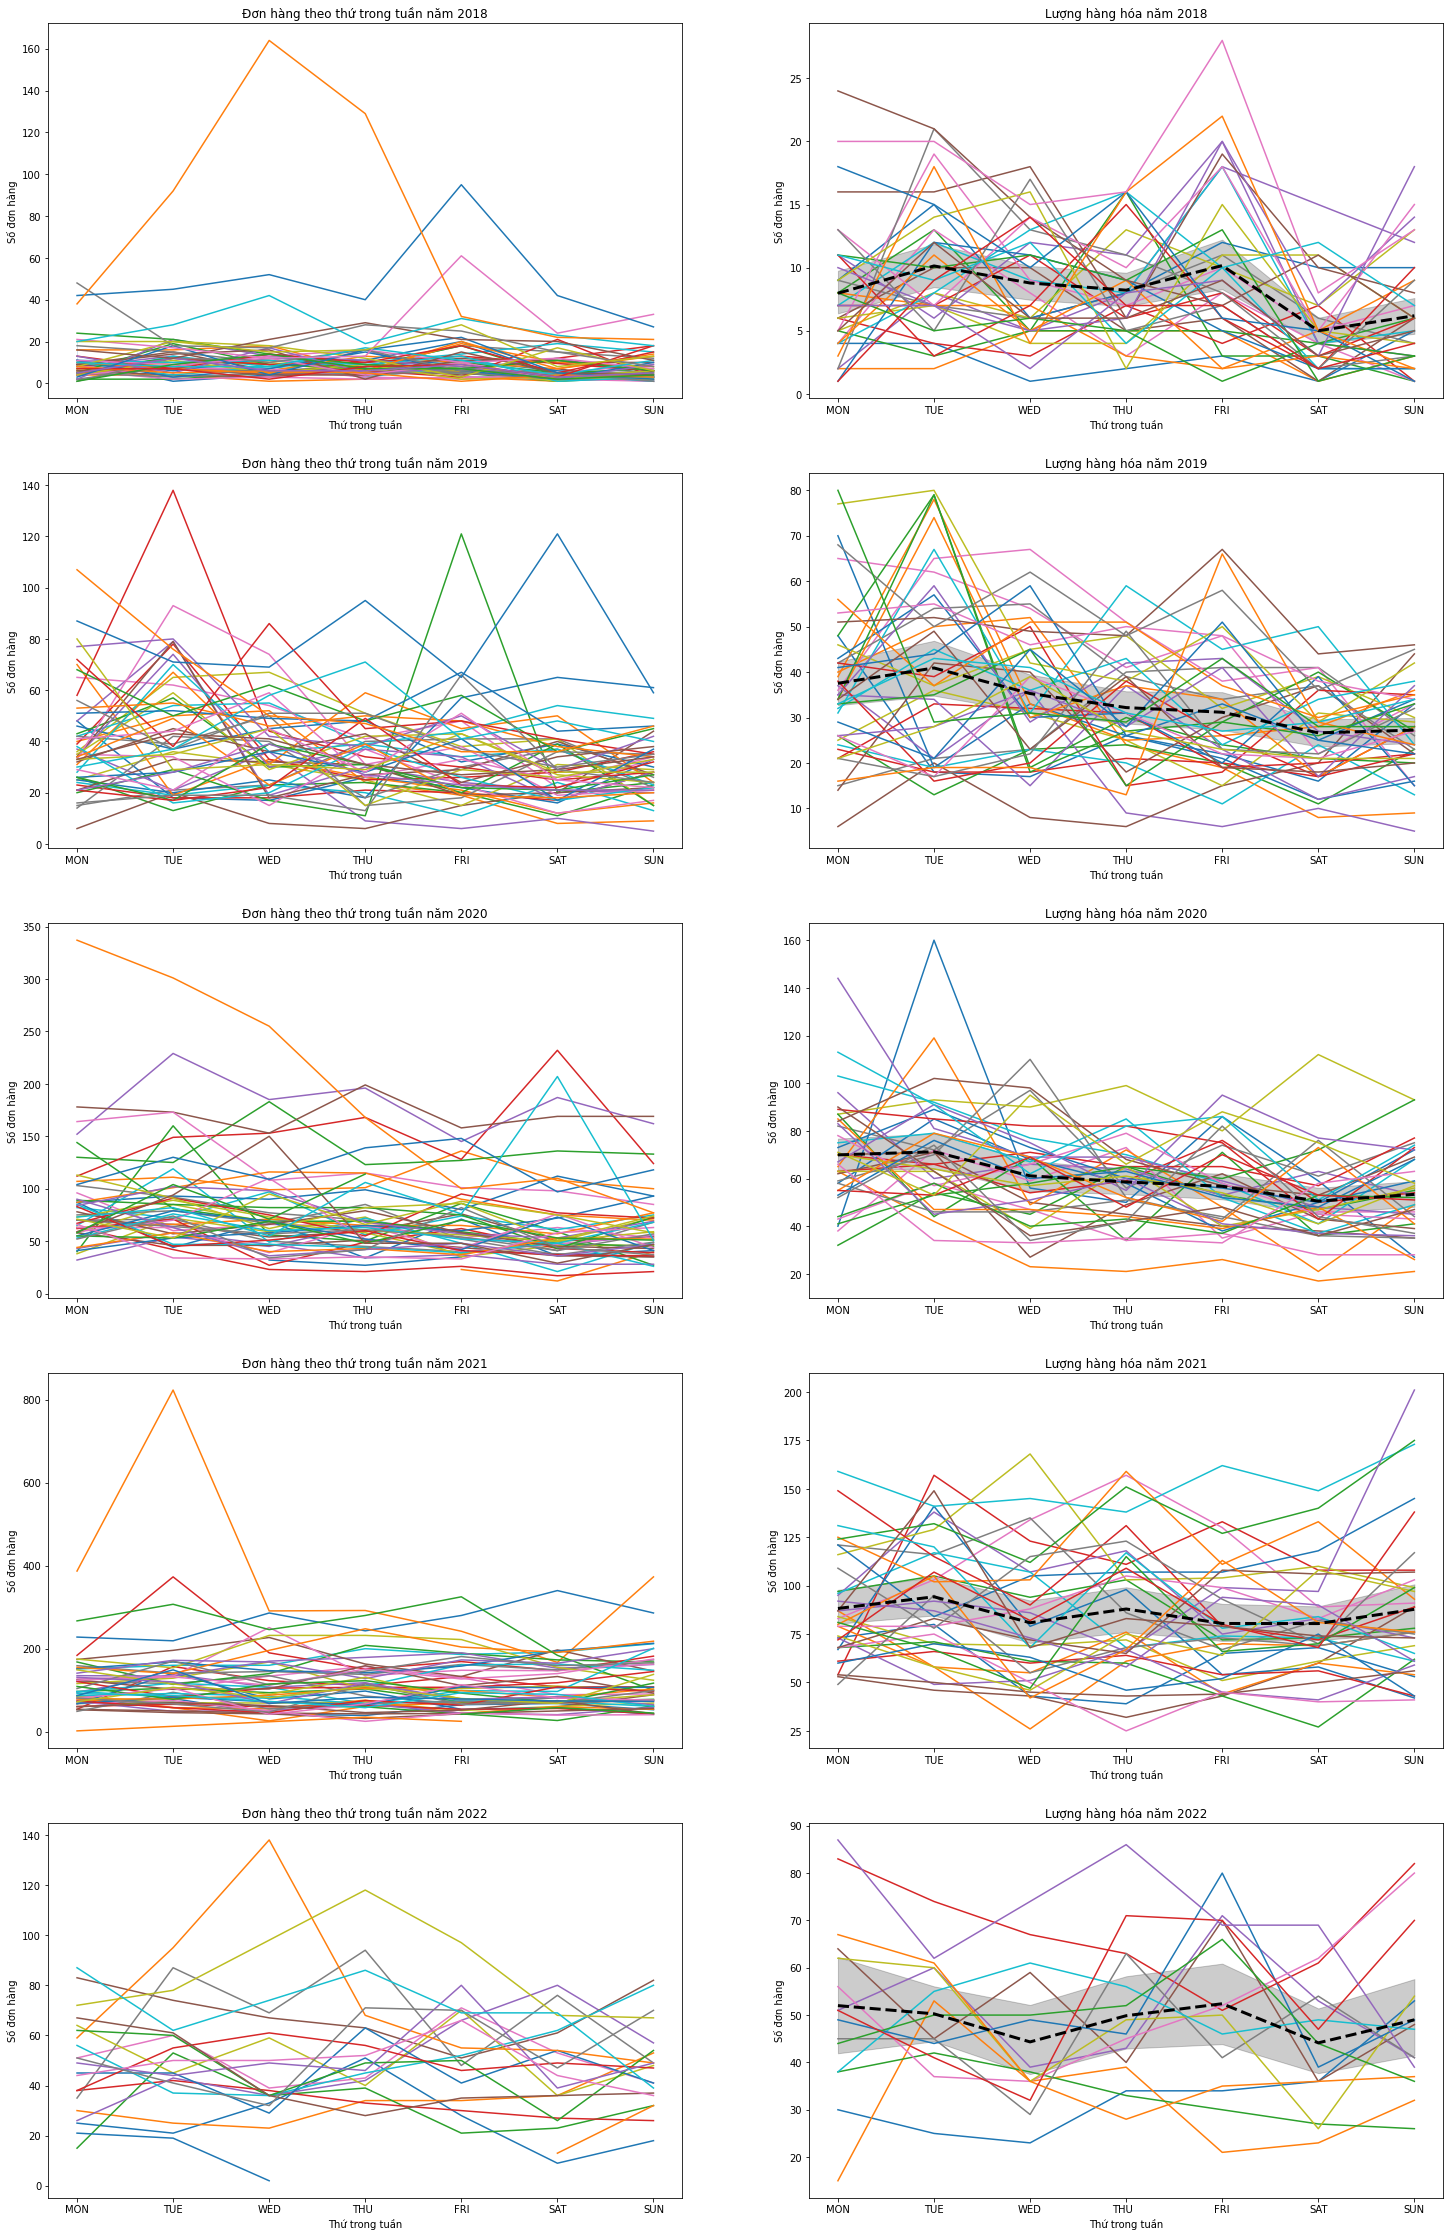

In [37]:
fig, ax = plt.subplots(5,2, figsize = (25, 40))
show_line_count_product_dayinweek(0, ax[0,0], ax[0,1])
show_line_count_product_dayinweek(1, ax[1,0], ax[1,1])
show_line_count_product_dayinweek(2, ax[2,0], ax[2,1])
show_line_count_product_dayinweek(3, ax[3,0], ax[3,1])
show_line_count_product_dayinweek(4, ax[4,0], ax[4,1])

In [38]:
def show_line_count_product_hour(index, ax1, ax2):

          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
                    .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date,
                              df['fhs_sales_flat_order_item.created_at'].dt.hour])\
                              ['fhs_sales_flat_order.entity_id'].count()
          df.index.names = ['fhs_sales_flat_order_item.created_at_date', 
                              'fhs_sales_flat_order_item.created_at_hour']
          # reset index đưa về dataframe
          df = df.reset_index()
          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at_date')

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at_hour'],
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax1,
                              hue = df['fhs_sales_flat_order_item.created_at_date'].dt.date, palette="tab10")

          ax1.set_title(f'Đơn hàng theo giờ trong ngày năm {2018 + index}')
          ax1.set_xlabel('Giờ trong ngày')
          ax1.set_ylabel('Số đơn hàng')
          ax1.get_legend().remove()
          

          # df = df.sort_values('fhs_sales_flat_order_item.created_at')
          # df['fhs_sales_flat_order.entity_id'] \
          #           = df['fhs_sales_flat_order.entity_id'].rolling(3).mean()

          before = len(df)

          df = df.groupby([df['fhs_sales_flat_order_item.created_at_date'], df['fhs_sales_flat_order_item.created_at_hour']])\
          ['fhs_sales_flat_order.entity_id'].aggregate('first').unstack()
          # df = df.reset_index()
          for hour in range(5, 20):
                    df = df[np.abs(stats.zscore(df[hour], nan_policy = 'omit')) < 4]
          df = df.stack().reset_index()
          after = len(df)

          df.columns = ['fhs_sales_flat_order_item.created_at_date', 'fhs_sales_flat_order_item.created_at_hour', 'fhs_sales_flat_order.entity_id']
          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at_hour'],
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax2,
                              hue = df['fhs_sales_flat_order_item.created_at_date'].dt.date, palette="tab10")

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at_hour'],
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax2,
                              linewidth = 3, color = 'black', linestyle='--')

          ax2.set_title(f'Tiền xử lí - Đơn hàng theo giờ trong ngày năm {2018 + index}')
          ax2.set_xlabel('Giờ trong ngày')
          ax2.set_ylabel('Số đơn hàng')

          try:
                    ax2.get_legend().remove()
          except:
                    print('nothing')

          print(f'Năm {2018 + index} có {before} mốc thời gian và {before - after} dòng ngoại lai từ 5:00 đến 20:00')

nothing
Năm 2018 có 1915 mốc thời gian và 1915 dòng ngoại lai từ 5:00 đến 20:00
nothing
Năm 2019 có 4482 mốc thời gian và 4482 dòng ngoại lai từ 5:00 đến 20:00
Năm 2020 có 5688 mốc thời gian và 5548 dòng ngoại lai từ 5:00 đến 20:00
Năm 2021 có 6232 mốc thời gian và 6135 dòng ngoại lai từ 5:00 đến 20:00
nothing
Năm 2022 có 2050 mốc thời gian và 2050 dòng ngoại lai từ 5:00 đến 20:00


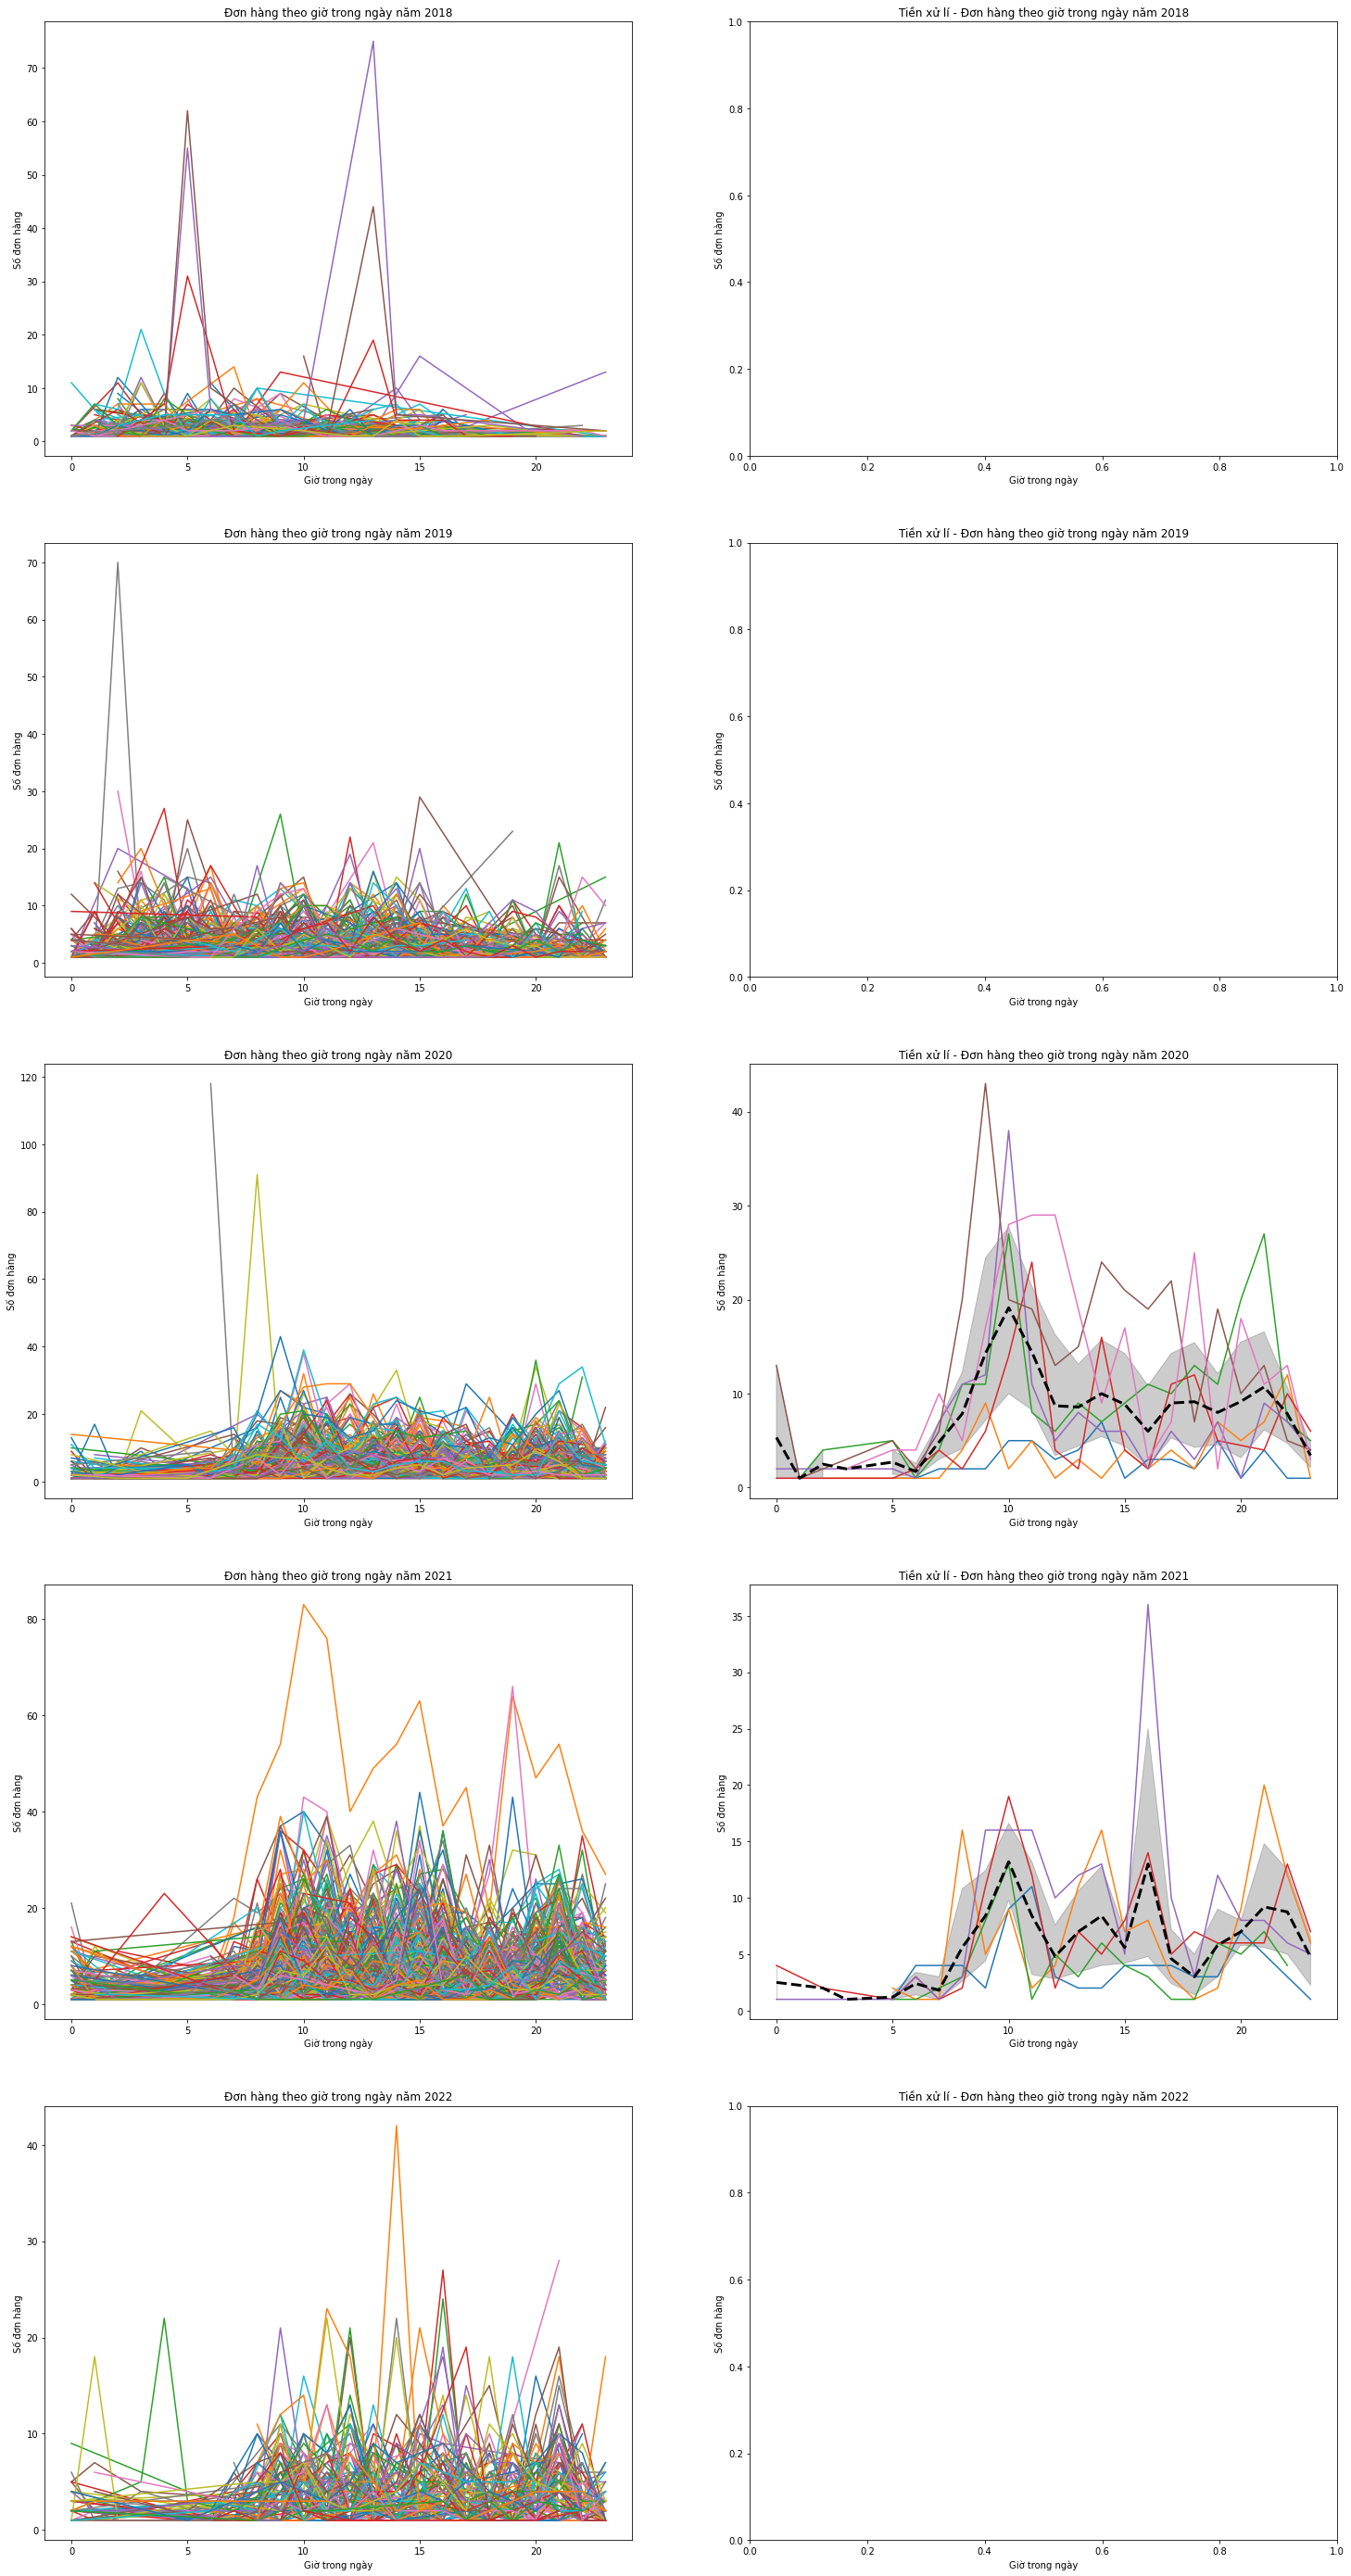

In [39]:
fig, ax = plt.subplots(5,2, figsize = (25, 50))
show_line_count_product_hour(0, ax[0, 0], ax[0, 1])
show_line_count_product_hour(1, ax[1, 0], ax[1, 1])
show_line_count_product_hour(2, ax[2, 0], ax[2, 1])
show_line_count_product_hour(3, ax[3, 0], ax[3, 1])
show_line_count_product_hour(4, ax[4, 0], ax[4, 1])

In [40]:

def show_bar_count_product_hour_year(index, ax1, ax2, ax3):
    df = fhs_sales_flat_order_item_state_list[index]

    df = df         \
            .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date,
                        df['fhs_sales_flat_order_item.created_at'].dt.hour])\
                        ['fhs_sales_flat_order.entity_id'].count()
    df.index.names = ['fhs_sales_flat_order_item.created_at_date', 
                        'fhs_sales_flat_order_item.created_at_hour']
    # reset index đưa về dataframe
    df = df.reset_index()
    # khi reset_index inedx đã đưa về sting nên ta cast về datetime
    string_to_datetime(df, 'fhs_sales_flat_order_item.created_at_date')

    s1 = df.groupby('fhs_sales_flat_order_item.created_at_hour')['fhs_sales_flat_order.entity_id'].mean()
    s1 = s1.reset_index()
    sns.barplot(data = s1, x = 'fhs_sales_flat_order_item.created_at_hour', y = 'fhs_sales_flat_order.entity_id', ax = ax1)

    for container in ax1.containers:
        labels = [f'{round(v.get_height())}' for i, v in enumerate(container)]
        ax1.bar_label(container, label_type='edge', labels = labels)

    ax1.set_title(f'Lượng hàng hóa bán vào các giờ trong ngày {2018 + index}')
    ax1.set_xlabel('Các giờ trong ngày')


    df = df.groupby([df['fhs_sales_flat_order_item.created_at_date'], df['fhs_sales_flat_order_item.created_at_hour']])\
            ['fhs_sales_flat_order.entity_id'].aggregate('first').unstack()
    # df = df.reset_index()
    for hour in range(5, 20):
            df = df[np.abs(stats.zscore(df[hour], nan_policy = 'omit')) < 4]
    df = df.stack().reset_index()
    after = len(df)

    df.columns = ['fhs_sales_flat_order_item.created_at_date', 'fhs_sales_flat_order_item.created_at_hour', 'fhs_sales_flat_order.entity_id']
    s2 = df.groupby('fhs_sales_flat_order_item.created_at_hour')['fhs_sales_flat_order.entity_id'].mean()
    s2 = s2.reset_index()

    try:
        sns.barplot(data = s2, x = 'fhs_sales_flat_order_item.created_at_hour', y = 'fhs_sales_flat_order.entity_id', ax = ax2)
    except:
        print('s2 rỗng')

    for container in ax2.containers:
        labels = [f'{round(v.get_height())}' for i, v in enumerate(container)]
        ax2.bar_label(container, label_type='edge', labels = labels)

    ax2.set_title(f'Tiền xử lí - Lượng hàng hóa bán vào các giờ trong ngày {2018 + index}')
    ax2.set_xlabel('Các giờ trong ngày')

    s3 = df.groupby('fhs_sales_flat_order_item.created_at_hour')['fhs_sales_flat_order.entity_id'].mean()

    def autopct(pct): # only show the label when it's > 10%
        return ('%.2f' % pct) if pct > 5 else ''

    s3.plot.pie(x = 'fhs_sales_flat_order_item.created_at_hour',
                        y = 'fhs_sales_flat_order.entity_id',ax = ax3, autopct = autopct)
    ax3.set_title(f'Phần trăm lượng hàng đặt torng ngày {2018 + index}')
    ax3.set_xlabel('')
    ax3.set_ylabel('')
    ax3.axes.get_yaxis().set_visible(False)
    ax3.legend(loc = 5, labels = [i for i in range(24)])

s2 rỗng
s2 rỗng
s2 rỗng


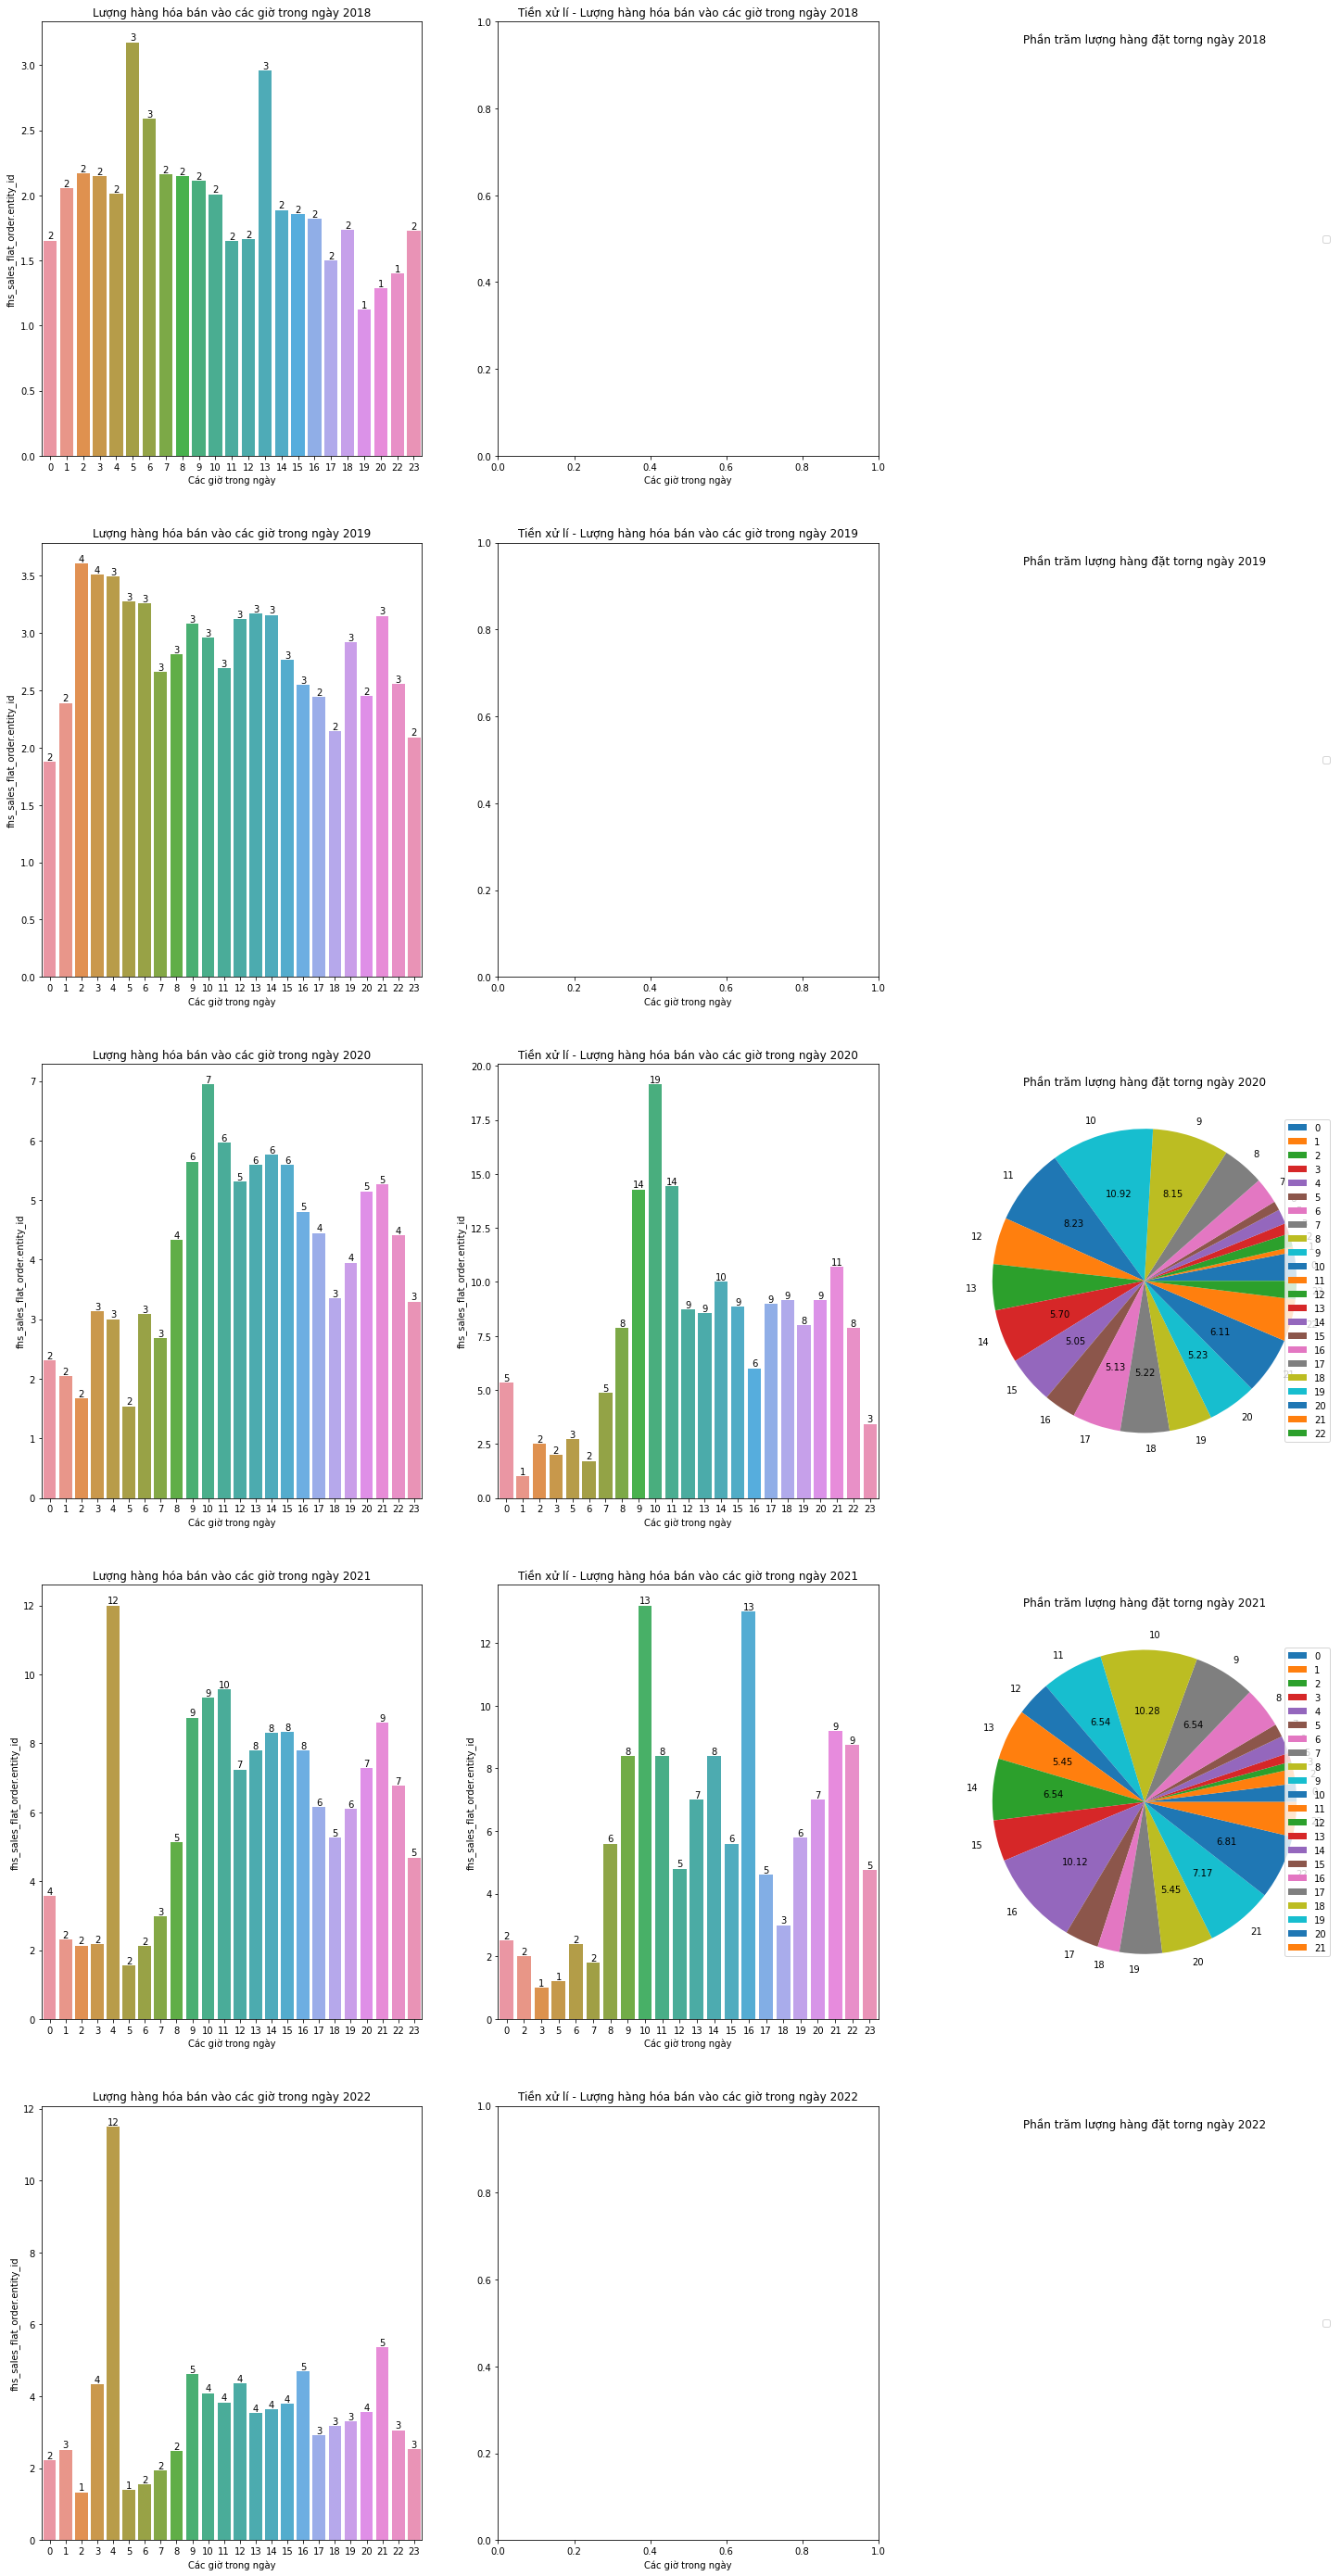

In [41]:
fig, ax = plt.subplots(5,3,figsize = (25,50))
show_bar_count_product_hour_year(0, ax[0,0], ax[0,1], ax[0,2])
show_bar_count_product_hour_year(1, ax[1,0], ax[1,1], ax[1,2])
show_bar_count_product_hour_year(2, ax[2,0], ax[2,1], ax[2,2])
show_bar_count_product_hour_year(3, ax[3,0], ax[3,1], ax[3,2])
show_bar_count_product_hour_year(4, ax[4,0], ax[4,1], ax[4,2])

- Check cực đại có phải ngày flashsale hay không, số lượng bán của hàng flashsale.
- Kiếm tra chính xác ngày trùng thnag1 7/7 8/8 9/9

- Show ra bảng là cực đại của ngày bán hàng, show tiếp tục những ngày có flashsale
- Concat 2 bảng lại xem có trùng nhiều không 
- Show những thứ bên lề như là doanh số bán hàng flashsale lỡ đâu bán hàng nhiều nhưng hàng flashsale ít thì sao
- Kiếm tra đặt biệt những ngày 7/7 8/8 9/9


In [42]:
fhs_flashsale_period_list = [fhs_flashsale_period_2018, fhs_flashsale_period_2019,
                              fhs_flashsale_period_2020, fhs_flashsale_period_2021, fhs_flashsale_period_2022]

fhs_flashsale_product_info_list = [fhs_flashsale_product_info_2018,fhs_flashsale_product_info_2019,
                    fhs_flashsale_product_info_2020,fhs_flashsale_product_info_2021,fhs_flashsale_product_info_2022]

In [43]:
def check_important_flashsale(index):
    df = fhs_sales_flat_order_item_state_list[index]

    df = df         \
            .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date])\
                        ['fhs_sales_flat_order.entity_id'].count()
    df = df.reset_index()
    string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

    def find_max_min_local(series, threshold = 800):
        """
            Input: 
                series: list
            Return:
                list of index
        """
        result = []
        for i in range(1, len(series) - 1):
            if series[i] > series[i - 1] and series[i] > series[i + 1]:
                temp = series[i]*2 - series[i - 1] - series[i + 1]
                if temp > threshold:
                    result.append(i)
            # elif series[i] < series[i - 1] and series[i] < series[i + 1]: 
            #     temp = series[i - 1] + series[i + 1] - series[i]*2
            #     if temp > threshold:
            #         result.append(i)
        return result

    result = find_max_min_local(df['fhs_sales_flat_order.entity_id'], 2000)

    result = pd.DataFrame(df['fhs_sales_flat_order_item.created_at'][result])

    before = len(result)

    period = fhs_flashsale_period_list[index]


    k = pd.DataFrame({'date':list(set(period.groupby(period['fhs_flashsale_period.start_date'].dt.date).keys))})
    string_to_datetime(k, 'date')

    result = pd.merge(result, k, left_on='fhs_sales_flat_order_item.created_at', right_on='date', how = 'left')
    after = len(result.dropna())

    print(f'Trong năm {2018 + index} những ngày xảy ra biến đổi mạnh về lượng bán trong ngày là {before} ngày.')
    try:
        print(f'Trong đó số ngày là flashsale chiếm {after} ngày. Đạt {round(after*1.0/before * 100, 2)}%')
    except:
        print('before = 0')

    return result, pd.DataFrame({'type': ['flashsale', 'no_flashsale'], 'amount': [after ,before - after]})



In [44]:
def check_flashsale_year(index):
        (temp, percent) = check_important_flashsale(index)

        temp = temp[['fhs_sales_flat_order_item.created_at']]
        df = fhs_sales_flat_order_item_state_list[index]
        flashsale_info = fhs_flashsale_product_info_list[index]

        df = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.date.isin(temp['fhs_sales_flat_order_item.created_at'].dt.date)]

        print(len(df))


        flashsale = \
                pd.merge(df, flashsale_info,
                        left_on = 'fhs_sales_flat_order_item.sku'
                        ,right_on = 'fhs_catalog_product_entity.sku')

        # Lấy các dòng sao cho lọt vào thời điểm flashsale
        flashsale = flashsale.loc[
                (flashsale['fhs_sales_flat_order_item.created_at'] \
                        > flashsale['fhs_flashsale_period.start_date'])
        &         (flashsale['fhs_sales_flat_order_item.created_at'] \
                        < flashsale['fhs_flashsale_period.end_date'])]

        # drop đi duplicate ở mỗi đơn hàng
        flashsale.drop_duplicates(subset = df.columns, inplace = True)

        # Cắt cột
        flashsale =\
                flashsale.loc[:, df.columns]
        print(len(flashsale))

        keys = list(df.columns)
        i1 = df.set_index(keys).index
        i2 = flashsale.set_index(keys).index

        no_flashsale = df.loc[~i1.isin(i2)]


        fig, ax = plt.subplots(1,2, figsize = (25, 10))

        def autopct(pct): # only show the label when it's > 10%
                return ('%.2f' % pct) if pct > 5 else ''

        try:
                percent.plot.pie(x = 'type', y = 'amount', labels = ['Số ngày flashsale', 'Số ngày không flashsale'],
                        ax = ax[0], autopct = autopct, explode = [0.2, 0], shadow = True)
        except:
                print('Lỗi gì đó')

        ax[0].set_ylabel('Phần trăm')
        ax[0].set_title(f'% Flashsale trong những ngày biến động năm {2018 + index}')

        percent_product = pd.DataFrame({'type':['flashsale', 'no_flashsale'], 'amount':[len(flashsale), len(no_flashsale)]})

        try:
                percent_product.plot.pie(x = 'type', y = 'amount', labels = ['Số sản phẩm flashsale', 'Số sản phẩm không flashsale'],
                        ax = ax[1], autopct = autopct, explode = [0.2, 0], shadow = True)
        except:
                print('Lỗi gì đó')

        ax[1].set_title(f'% Số lượng hàng flashsale trong những ngày biến động năm {2018 + index}')
        ax[1].set_ylabel('Phần trăm')
        fig.patch.set_facecolor('white')

        # df là các đơn hàng tổng thể
        # flashsale là đơn hàng được flashsale
        # no_flashsale là đơn hàng không flashsale

        df = df.groupby(df['fhs_sales_flat_order_item.created_at'].dt.date)['fhs_sales_flat_order.entity_id'].count()
        df = df.reset_index()

        flashsale = flashsale.groupby(flashsale['fhs_sales_flat_order_item.created_at'].dt.date)['fhs_sales_flat_order.entity_id'].count()
        flashsale = flashsale.reset_index()

        no_flashsale = no_flashsale.groupby(no_flashsale['fhs_sales_flat_order_item.created_at'].dt.date)['fhs_sales_flat_order.entity_id'].count()
        no_flashsale = no_flashsale.reset_index()



        string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
        string_to_datetime(flashsale, 'fhs_sales_flat_order_item.created_at')
        string_to_datetime(no_flashsale, 'fhs_sales_flat_order_item.created_at')


        df = pd.merge(df, flashsale, left_on= df['fhs_sales_flat_order_item.created_at'].dt.date, 
                right_on = flashsale['fhs_sales_flat_order_item.created_at'].dt.date, how = 'left', )

        df = df.loc[:, ['key_0', 'fhs_sales_flat_order.entity_id_x', 'fhs_sales_flat_order.entity_id_y']]
        df.columns = ['date','total','flashsale']
        string_to_datetime(df, 'date')
        df = pd.merge(df, no_flashsale, left_on= df['date'].dt.date, 
                right_on = no_flashsale['fhs_sales_flat_order_item.created_at'].dt.date, how = 'left')
        df = df.loc[:, ['date','total','flashsale', 'fhs_sales_flat_order.entity_id']]
        df.columns = ['date','total','flashsale', 'no_flashsale']


        df = df.reindex(['date', 'flashsale', 'no_flashsale', 'total'], axis = 1)
        df = df.melt(id_vars = 'date', value_name = 'amount', var_name = 'type')
        df = df.sort_values('date')

        fig, ax = plt.subplots(1,1, figsize = (25, 10))
        
        try:
                sns.barplot(data = df, x = df['date'].dt.strftime('%m-%d'), y = 'amount', hue = 'type', ax = ax)
        except:
                        print('Lỗi gì đó')      
        # def change_nan(x):
        #         if str(x) == 'nan':
        #                 return 0
        #         else:
        #                 return x


        # # for index, container in enumerate(ax[0].containers):
        # #         if index != 2:
        # #                 labels = [f'{round(change_nan(v.get_height()))}' for i, v in enumerate(container)]
        # #                 ax[0].bar_label(container, label_type='edge', labels = labels)
        # #         else:
        # #                 labels = [f'{round(change_nan(v.get_height()))}' for i, v in enumerate(container)]
        # #                 ax[0].bar_label(container, label_type='center', labels = labels)
        
        ax.set_xlabel('Những ngày bán hàng biến động')
        ax.set_ylabel('Lượng hàng bán ra')
        ax.set_title(f'Lượng hàng bán flashsale và không flashsale torng những ngày biến động năm {2018 + index}')
        # ax.xaxis.set_major_locator(mdates.DayLocator((1,15)))


Trong năm 2018 những ngày xảy ra biến đổi mạnh về lượng bán trong ngày là 0 ngày.
before = 0
0
0
Lỗi gì đó
Lỗi gì đó
Lỗi gì đó
Trong năm 2019 những ngày xảy ra biến đổi mạnh về lượng bán trong ngày là 0 ngày.
before = 0
0
0
Lỗi gì đó
Lỗi gì đó
Lỗi gì đó
Trong năm 2020 những ngày xảy ra biến đổi mạnh về lượng bán trong ngày là 0 ngày.
before = 0
0


/home/it/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3056: RuntimeWarning: invalid value encountered in divide
  x = x / sx
/home/it/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3056: RuntimeWarning: invalid value encountered in divide
  x = x / sx


0


/home/it/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3056: RuntimeWarning: invalid value encountered in divide
  x = x / sx


Lỗi gì đó
Lỗi gì đó
Lỗi gì đó
Trong năm 2021 những ngày xảy ra biến đổi mạnh về lượng bán trong ngày là 0 ngày.
before = 0
0
0


/home/it/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3056: RuntimeWarning: invalid value encountered in divide
  x = x / sx
/home/it/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3056: RuntimeWarning: invalid value encountered in divide
  x = x / sx


Lỗi gì đó
Lỗi gì đó
Lỗi gì đó
Trong năm 2022 những ngày xảy ra biến đổi mạnh về lượng bán trong ngày là 0 ngày.
before = 0
0
0
Lỗi gì đó
Lỗi gì đó
Lỗi gì đó


ValueError: need at least one array to concatenate

<Figure size 1800x720 with 2 Axes>

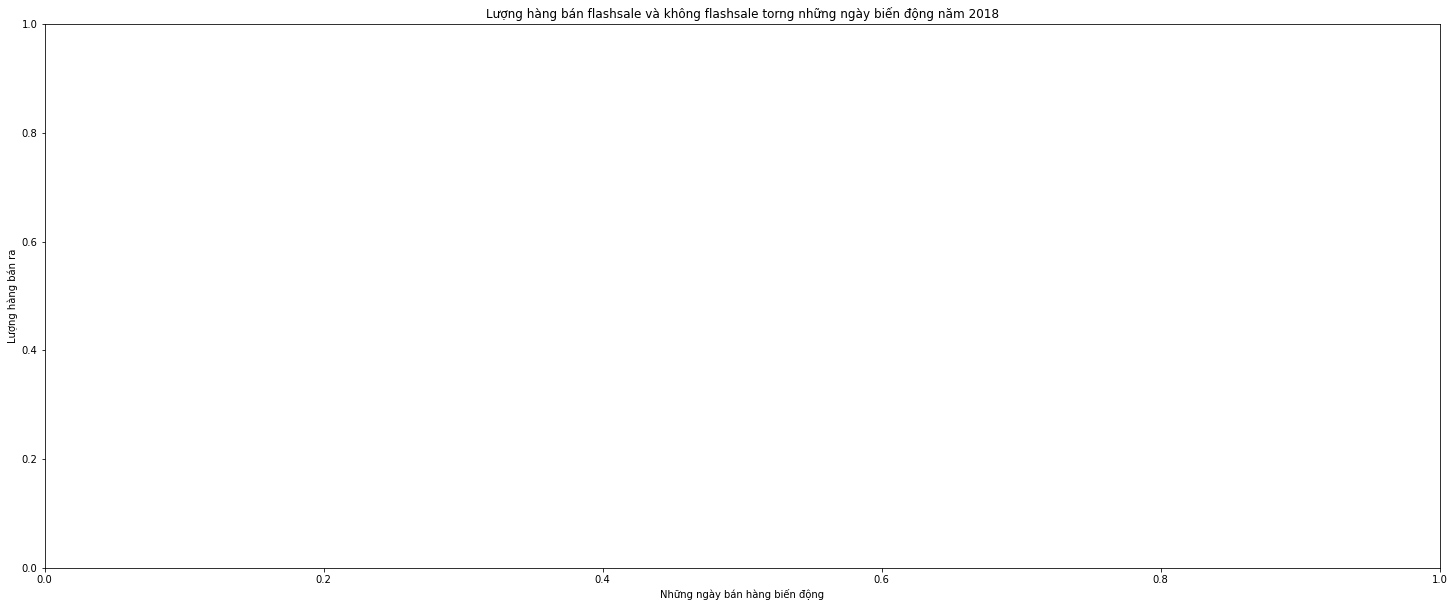

ValueError: need at least one array to concatenate

<Figure size 1800x720 with 2 Axes>

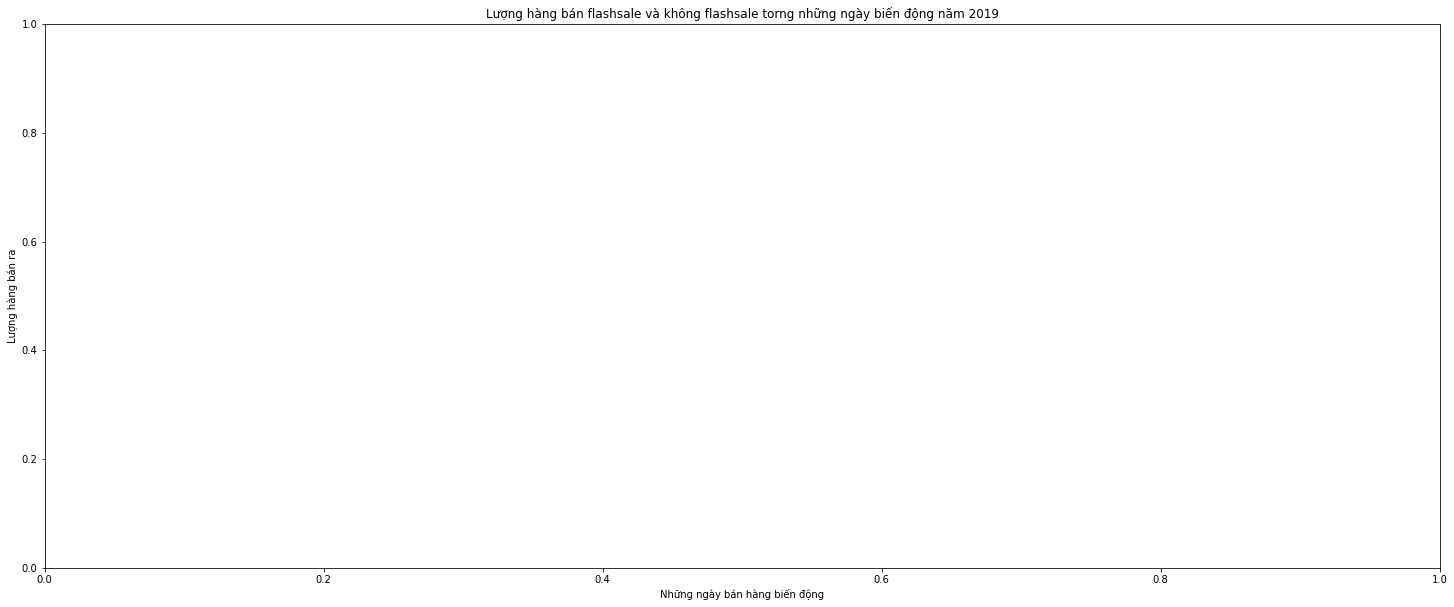

ValueError: need at least one array to concatenate

<Figure size 1800x720 with 2 Axes>

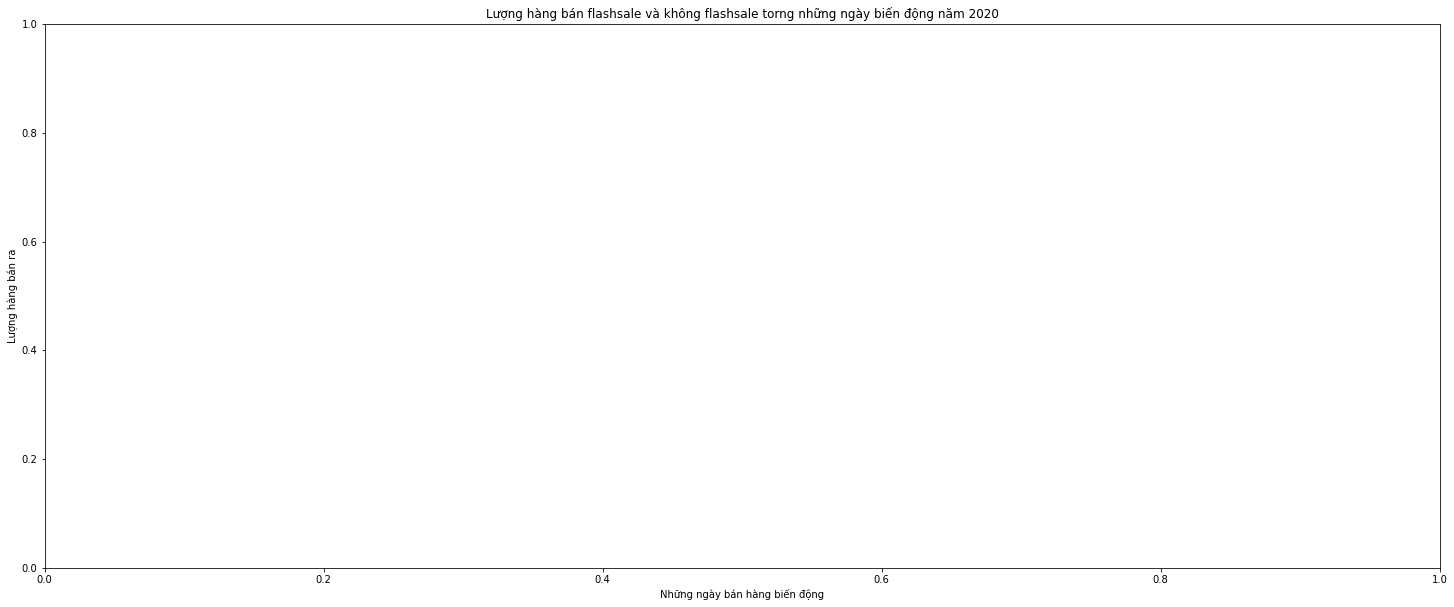

ValueError: need at least one array to concatenate

<Figure size 1800x720 with 2 Axes>

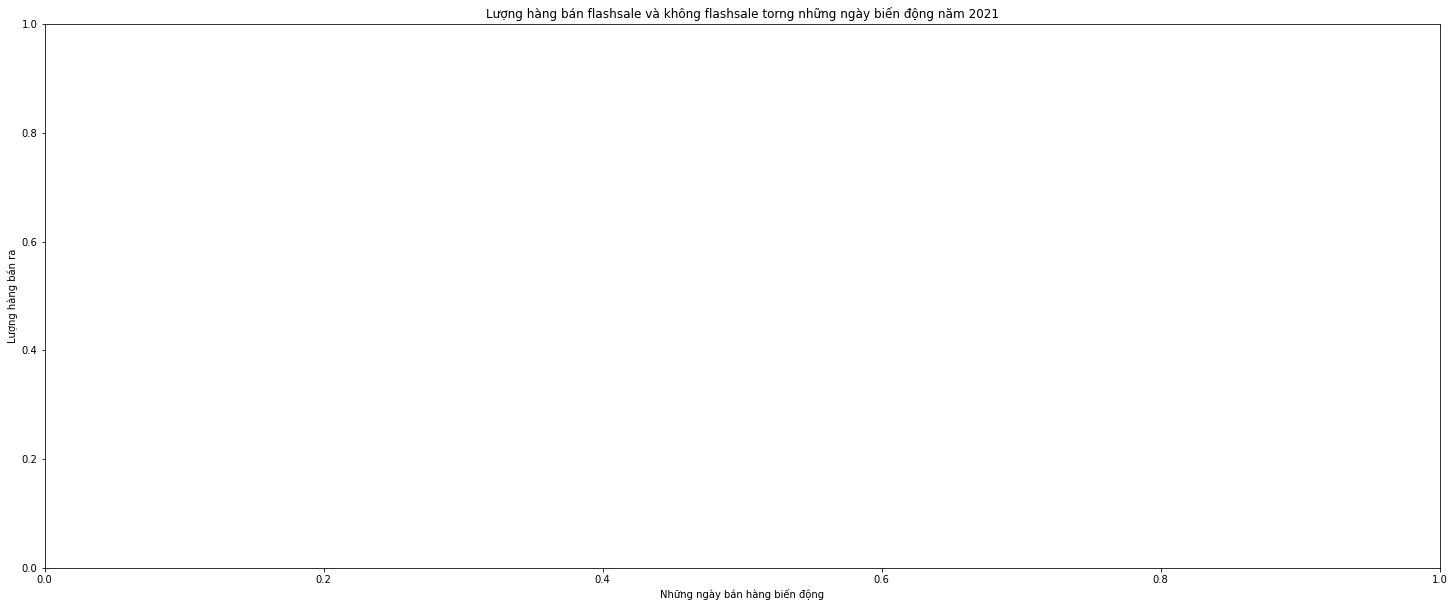

ValueError: need at least one array to concatenate

<Figure size 1800x720 with 2 Axes>

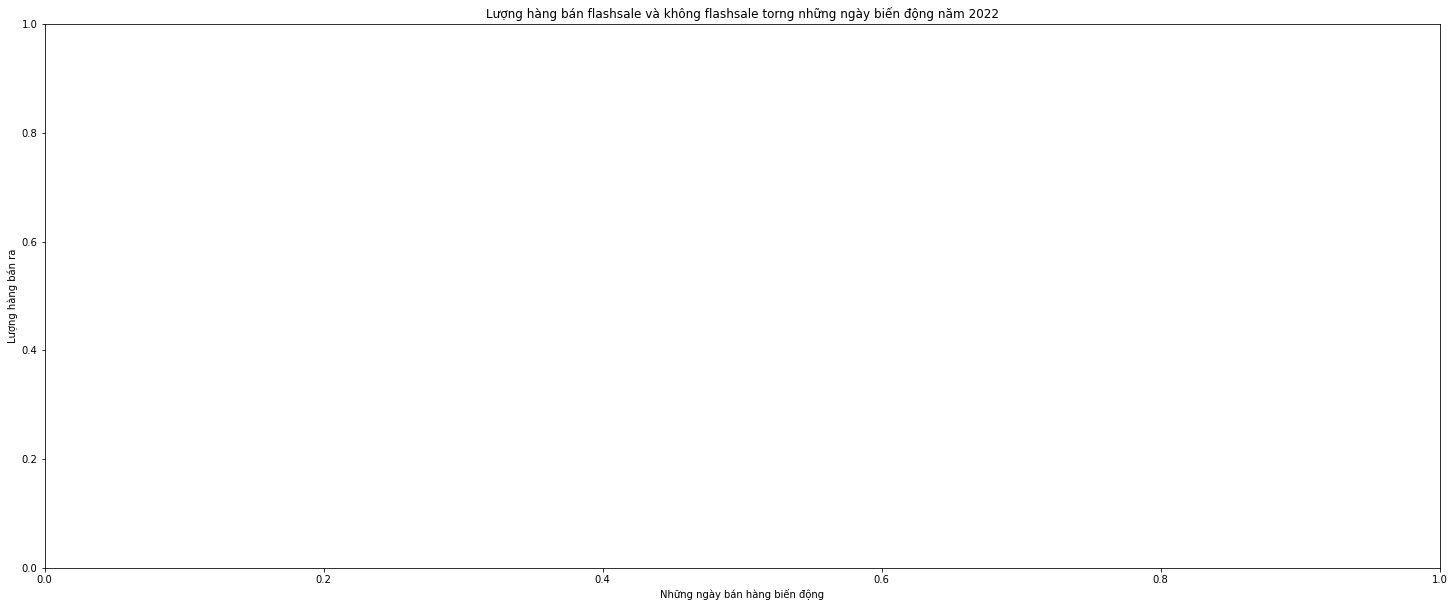

In [45]:
check_flashsale_year(0)
check_flashsale_year(1)
check_flashsale_year(2)
check_flashsale_year(3)
check_flashsale_year(4)